In [1]:
# Models to try based on the results
# 1. Random Forest Classifier
# 2. LightGBM Classifier
# 3. XGBoost Classifier
# 4. Decision Tree
# 5. KNN
# 6. Gradient Boosting
# 7. Naive Bayes
# 8. Support Vector Classifier
# 9. MLP Classifier Sklearn


# Eval also on ROC

import pandas as pd
import numpy as np
from time import time
from sklearn.model_selection import cross_validate, LeaveOneOut
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, make_scorer, precision_score, recall_score, f1_score, roc_auc_score

# Models
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier



import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Train and test data
approaches = {'Initial': ['real_data', 'synth_data'], 'Extra': ['real_data', 'real_pseudoreal_data', 'real_pseudoreal_synth_data']}
models = {
    'RandomForest': RandomForestClassifier(random_state=42, n_jobs=-1),
    'LightGBM': LGBMClassifier(random_state=42, n_jobs=-1, verbose=-1337),
    'XGBoost': XGBClassifier(random_state=42, n_jobs=-1),
    'KNN': KNeighborsClassifier(n_jobs=-1),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'NaiveBayes': GaussianNB(),
    'SVC': SVC(random_state=42, probability=True),
    'MLP': MLPClassifier(random_state=42)
}
# Define the scoring metrics
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='macro'),
    'recall': make_scorer(recall_score, average='macro'),
    'f1': make_scorer(f1_score, average='macro'),
}

results = {}
cm = {}
fi = {}

total = len(approaches) * sum(len(datasets) for datasets in approaches.values()) * len(models)
print(f"Total combinations to process: {total}")

iter = 0

for approach, datasets in approaches.items():
    for dataset in datasets:
        iter += 1
        print(f"Processing {approach} - {dataset} ({iter}/{total})")
        
        # Load the preprocessed data
        X_train = pd.read_csv(f"./datasets/preprocessed/{approach}/{dataset}/X_train.csv")
        y_train = pd.read_csv(f"./datasets/preprocessed/{approach}/{dataset}/y_train.csv")
        X_test = pd.read_csv(f"./datasets/preprocessed/{approach}/{dataset}/X_test.csv")
        y_test = pd.read_csv(f"./datasets/preprocessed/{approach}/{dataset}/y_test.csv")
        

        # Train the models
        for model_name, model in models.items():
            print(f"Training {model_name} on {approach} - {dataset}...")
            if X_train.shape[0] < 500:
                cv = LeaveOneOut()  # Use LOO for very small datasets
            else:
                # Count samples in smallest class
                class_counts = y_train.value_counts()
                min_class_samples = class_counts.min()
                

                n_splits = min(5, min_class_samples)  # Use at most 5 splits, but no more than samples in smallest class
                cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
            
            cv_type = 'LeaveOneOut' if isinstance(cv, LeaveOneOut) else f'StratifiedKFold with {n_splits} splits'
            cv_results = cross_validate(model, X_train, y_train.values.ravel(), cv=cv, scoring=scoring)
            
            
            # Calculate the mean and standard deviation of the scores
            mean_accuracy = np.mean(cv_results['test_accuracy'])
            std_accuracy = np.std(cv_results['test_accuracy'])
            mean_precision = np.mean(cv_results['test_precision'])
            std_precision = np.std(cv_results['test_precision'])
            mean_recall = np.mean(cv_results['test_recall'])
            std_recall = np.std(cv_results['test_recall'])
            mean_f1 = np.mean(cv_results['test_f1'])
            std_f1 = np.std(cv_results['test_f1'])

            
            # Fit the model on the entire training set
            model.fit(X_train, y_train.values.ravel())
            
            # Make predictions on the test set
            y_pred = model.predict(X_test)
            
            # Calculate the test set metrics
            test_accuracy = accuracy_score(y_test, y_pred)
            test_precision = precision_score(y_test, y_pred, average='macro')
            test_recall = recall_score(y_test, y_pred, average='macro')
            test_f1 = f1_score(y_test, y_pred, average='macro')
            test_roc_auc = roc_auc_score(y_test, model.predict_proba(X_test), multi_class='ovr', average='macro')
            
            results[(approach, dataset, model_name)] = {
                'cv_type': cv_type,	
                'test_accuracy': test_accuracy,
                'test_precision': test_precision,
                'test_recall': test_recall,
                'test_f1': test_f1,
            }
            
            # Store the confusion matrix
            cm[(approach, dataset, model_name)] = pd.crosstab(y_test.values.ravel(), y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
            
            # Feature importance
            if hasattr(model, 'feature_importances_'):
                fi[(approach, dataset, model_name)] = pd.DataFrame({
                    'Feature': X_train.columns,
                    'Importance': model.feature_importances_
                }).sort_values(by='Importance', ascending=False)
            elif hasattr(model, 'coef_'):
                fi[(approach, dataset, model_name)] = pd.DataFrame({
                    'Feature': X_train.columns,
                    'Importance': np.abs(model.coef_[0])
                }).sort_values(by='Importance', ascending=False)
            else:
                fi[(approach, dataset, model_name)] = None
        
        
        

Training RandomForest on Initial - real_data...
Training LightGBM on Initial - real_data...
Training XGBoost on Initial - real_data...
Training KNN on Initial - real_data...
Training DecisionTree on Initial - real_data...
Training GradientBoosting on Initial - real_data...
Training NaiveBayes on Initial - real_data...
Training SVC on Initial - real_data...


/home/iven/.pyenv/versions/3.12.9/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/iven/.pyenv/versions/3.12.9/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/iven/.pyenv/versions/3.12.9/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

Training MLP on Initial - real_data...


/home/iven/.pyenv/versions/3.12.9/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/iven/.pyenv/versions/3.12.9/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/iven/.pyenv/versions/3.12.9/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/iven/.pyenv/versions/3.12.9/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warning

Training RandomForest on Initial - synth_data...
Training LightGBM on Initial - synth_data...
Training XGBoost on Initial - synth_data...
Training KNN on Initial - synth_data...
Training DecisionTree on Initial - synth_data...
Training GradientBoosting on Initial - synth_data...
Training NaiveBayes on Initial - synth_data...
Training SVC on Initial - synth_data...
Training MLP on Initial - synth_data...


/home/iven/.pyenv/versions/3.12.9/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/iven/.pyenv/versions/3.12.9/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/iven/.pyenv/versions/3.12.9/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/iven/.pyenv/versions/3.12.9/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warning

Training RandomForest on Extra - real_data...


/home/iven/.pyenv/versions/3.12.9/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/iven/.pyenv/versions/3.12.9/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/iven/.pyenv/versions/3.12.9/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", l

Training LightGBM on Extra - real_data...


/home/iven/.pyenv/versions/3.12.9/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/iven/.pyenv/versions/3.12.9/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/iven/.pyenv/versions/3.12.9/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", l

Training XGBoost on Extra - real_data...


/home/iven/.pyenv/versions/3.12.9/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/iven/.pyenv/versions/3.12.9/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/iven/.pyenv/versions/3.12.9/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", l

Training KNN on Extra - real_data...


/home/iven/.pyenv/versions/3.12.9/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/iven/.pyenv/versions/3.12.9/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/iven/.pyenv/versions/3.12.9/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", l

Training DecisionTree on Extra - real_data...


/home/iven/.pyenv/versions/3.12.9/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/iven/.pyenv/versions/3.12.9/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/iven/.pyenv/versions/3.12.9/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", l

Training GradientBoosting on Extra - real_data...


/home/iven/.pyenv/versions/3.12.9/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/iven/.pyenv/versions/3.12.9/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/iven/.pyenv/versions/3.12.9/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", l

Training NaiveBayes on Extra - real_data...


/home/iven/.pyenv/versions/3.12.9/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/iven/.pyenv/versions/3.12.9/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/iven/.pyenv/versions/3.12.9/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", l

Training SVC on Extra - real_data...


/home/iven/.pyenv/versions/3.12.9/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/iven/.pyenv/versions/3.12.9/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/iven/.pyenv/versions/3.12.9/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", l

Training MLP on Extra - real_data...


/home/iven/.pyenv/versions/3.12.9/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/iven/.pyenv/versions/3.12.9/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/iven/.pyenv/versions/3.12.9/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/iven/.pyenv/versions/3.12.9/lib/python3.12/site-packages/sklearn/neura

Training RandomForest on Extra - real_pseudoreal_data...
Training LightGBM on Extra - real_pseudoreal_data...
Training XGBoost on Extra - real_pseudoreal_data...
Training KNN on Extra - real_pseudoreal_data...
Training DecisionTree on Extra - real_pseudoreal_data...
Training GradientBoosting on Extra - real_pseudoreal_data...
Training NaiveBayes on Extra - real_pseudoreal_data...
Training SVC on Extra - real_pseudoreal_data...


/home/iven/.pyenv/versions/3.12.9/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/iven/.pyenv/versions/3.12.9/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/iven/.pyenv/versions/3.12.9/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

Training MLP on Extra - real_pseudoreal_data...


/home/iven/.pyenv/versions/3.12.9/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/iven/.pyenv/versions/3.12.9/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/iven/.pyenv/versions/3.12.9/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/iven/.pyenv/versions/3.12.9/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warning

Training RandomForest on Extra - real_pseudoreal_synth_data...


/home/iven/.pyenv/versions/3.12.9/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training LightGBM on Extra - real_pseudoreal_synth_data...


/home/iven/.pyenv/versions/3.12.9/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training XGBoost on Extra - real_pseudoreal_synth_data...


/home/iven/.pyenv/versions/3.12.9/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training KNN on Extra - real_pseudoreal_synth_data...
Training DecisionTree on Extra - real_pseudoreal_synth_data...


/home/iven/.pyenv/versions/3.12.9/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training GradientBoosting on Extra - real_pseudoreal_synth_data...


/home/iven/.pyenv/versions/3.12.9/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/iven/.pyenv/versions/3.12.9/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training NaiveBayes on Extra - real_pseudoreal_synth_data...
Training SVC on Extra - real_pseudoreal_synth_data...


/home/iven/.pyenv/versions/3.12.9/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training MLP on Extra - real_pseudoreal_synth_data...


/home/iven/.pyenv/versions/3.12.9/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/iven/.pyenv/versions/3.12.9/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/iven/.pyenv/versions/3.12.9/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/iven/.pyenv/versions/3.12.9/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warning

In [3]:
# Print the results
for (approach, dataset, model_name), metrics in results.items():
    print(f"Results for {model_name} on {approach} - {dataset}:")
    print(f"Cross-validation type: {metrics['cv_type']}")
    print(f"Test Accuracy: {metrics['test_accuracy']:.4f}")
    print(f"Test Precision: {metrics['test_precision']:.4f}")
    print(f"Test Recall: {metrics['test_recall']:.4f}")
    print(f"Test F1 Score: {metrics['test_f1']:.4f}")
    print("-" * 50)

Results for RandomForest on Initial - real_data:
Cross-validation type: StratifiedKFold with 5 splits
Test Accuracy: 0.8318
Test Precision: 0.8298
Test Recall: 0.8261
Test F1 Score: 0.8251
--------------------------------------------------
Results for LightGBM on Initial - real_data:
Cross-validation type: StratifiedKFold with 5 splits
Test Accuracy: 0.8057
Test Precision: 0.8015
Test Recall: 0.8038
Test F1 Score: 0.8021
--------------------------------------------------
Results for XGBoost on Initial - real_data:
Cross-validation type: StratifiedKFold with 5 splits
Test Accuracy: 0.8057
Test Precision: 0.8012
Test Recall: 0.8021
Test F1 Score: 0.8013
--------------------------------------------------
Results for KNN on Initial - real_data:
Cross-validation type: StratifiedKFold with 5 splits
Test Accuracy: 0.7322
Test Precision: 0.7322
Test Recall: 0.7258
Test F1 Score: 0.7172
--------------------------------------------------
Results for DecisionTree on Initial - real_data:
Cross-val

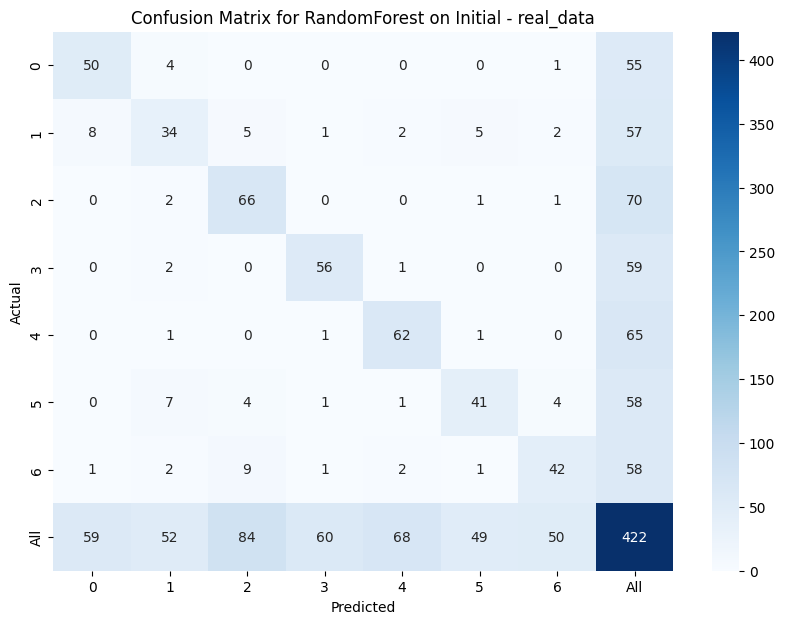

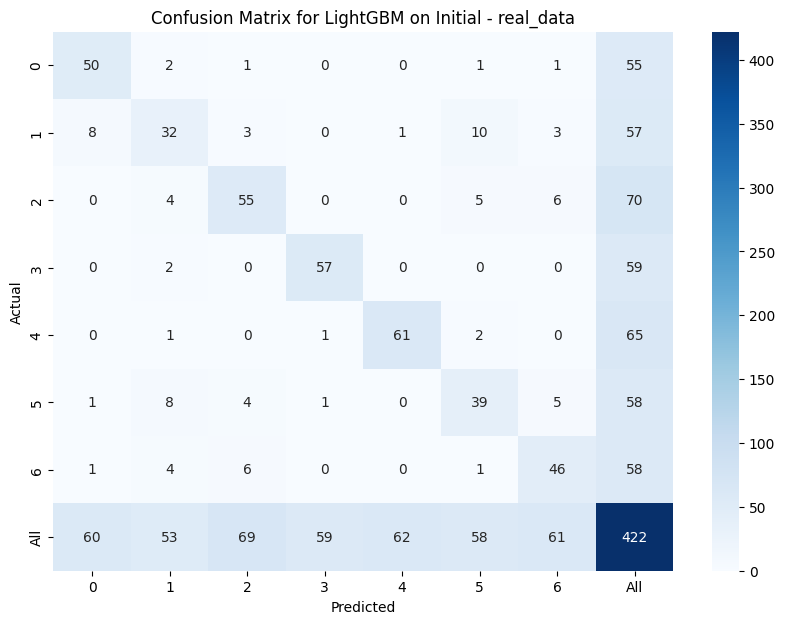

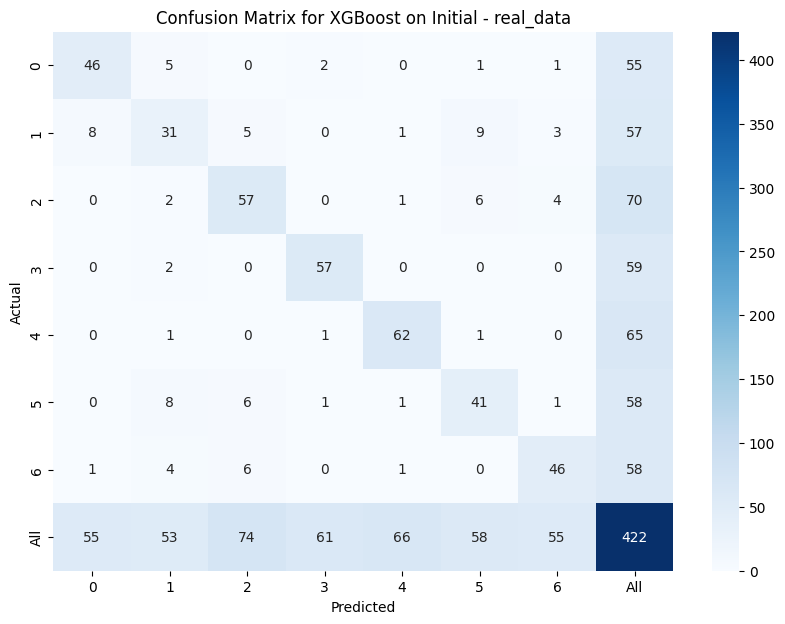

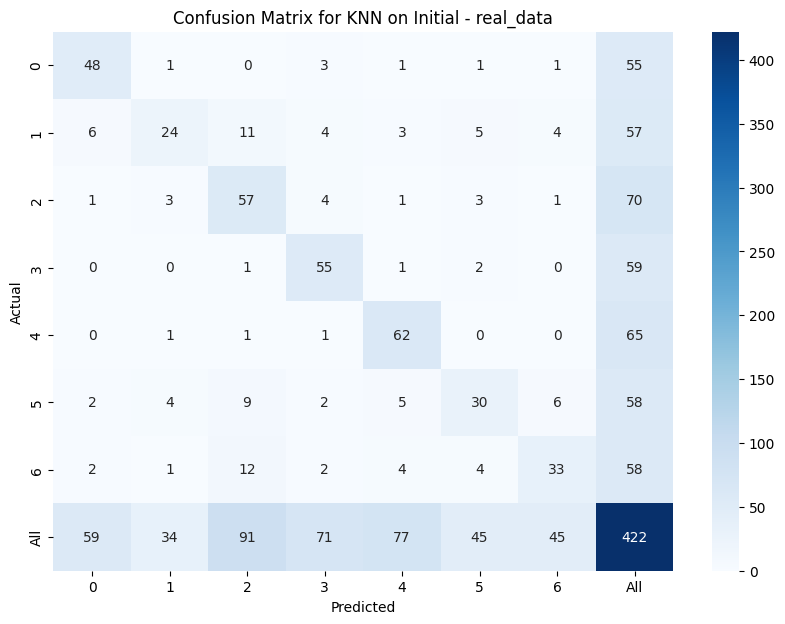

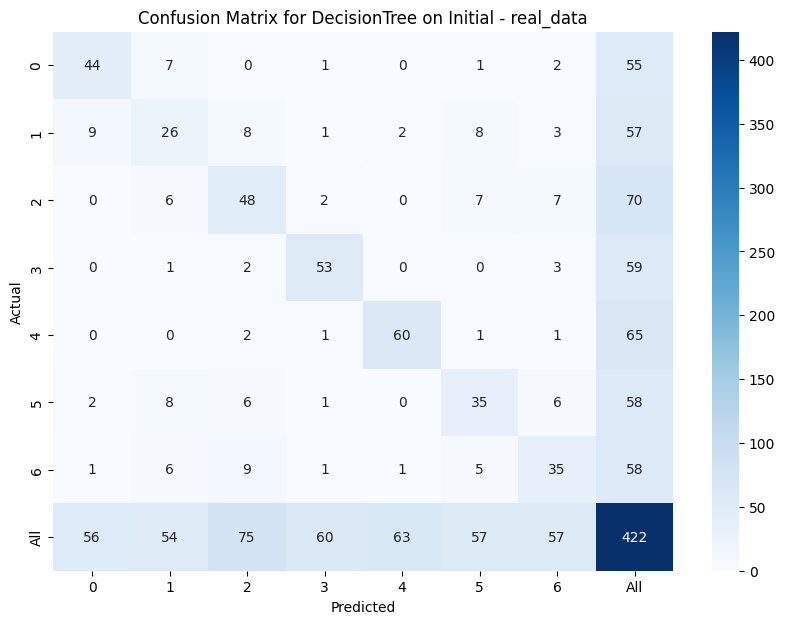

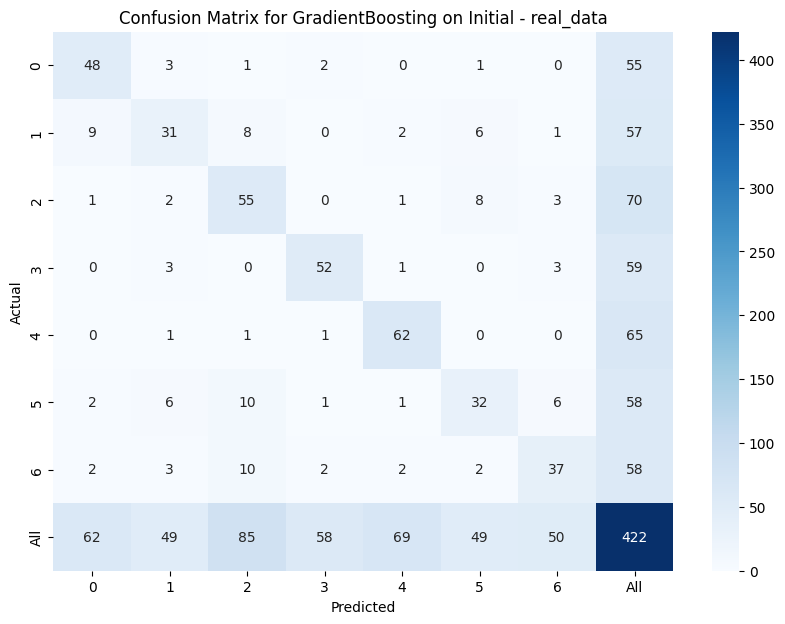

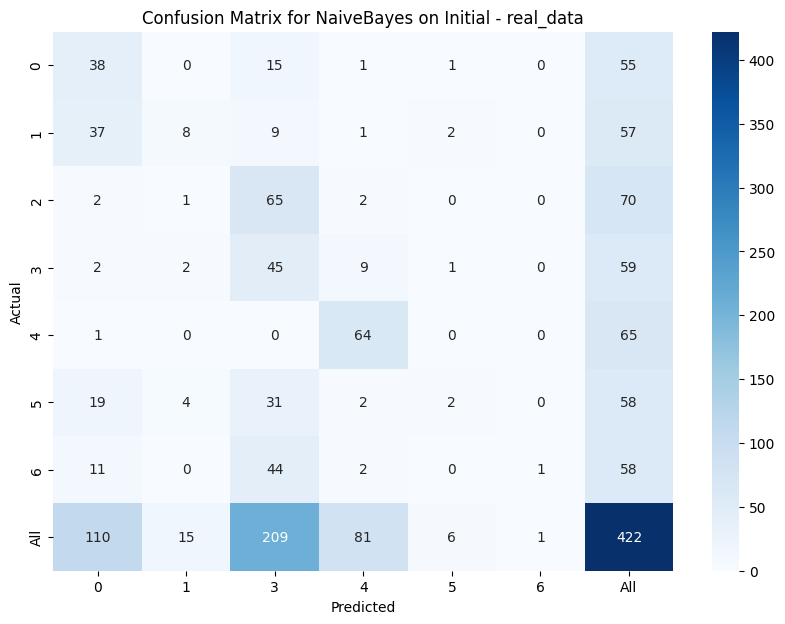

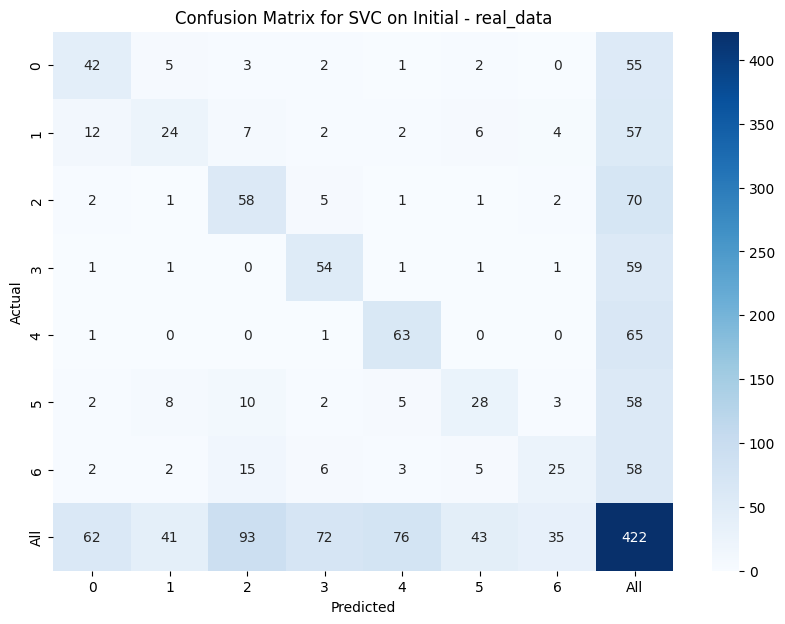

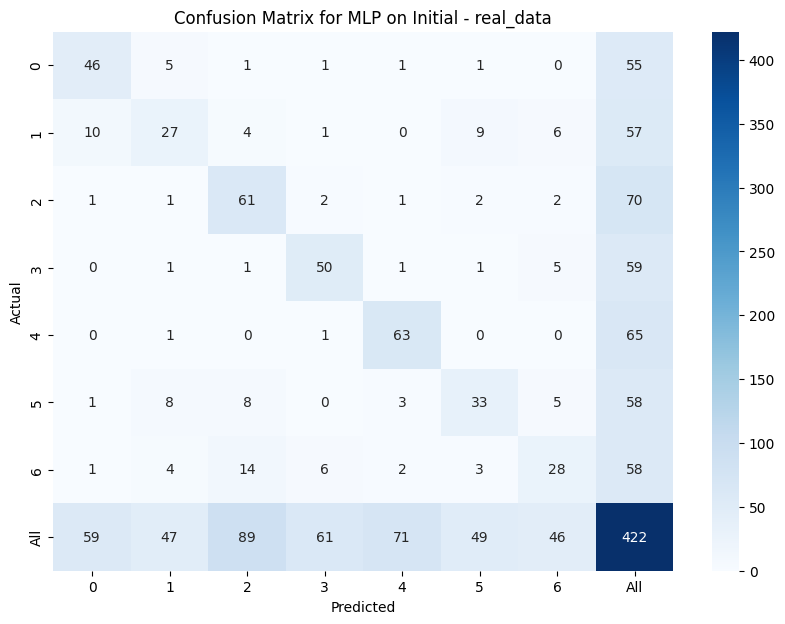

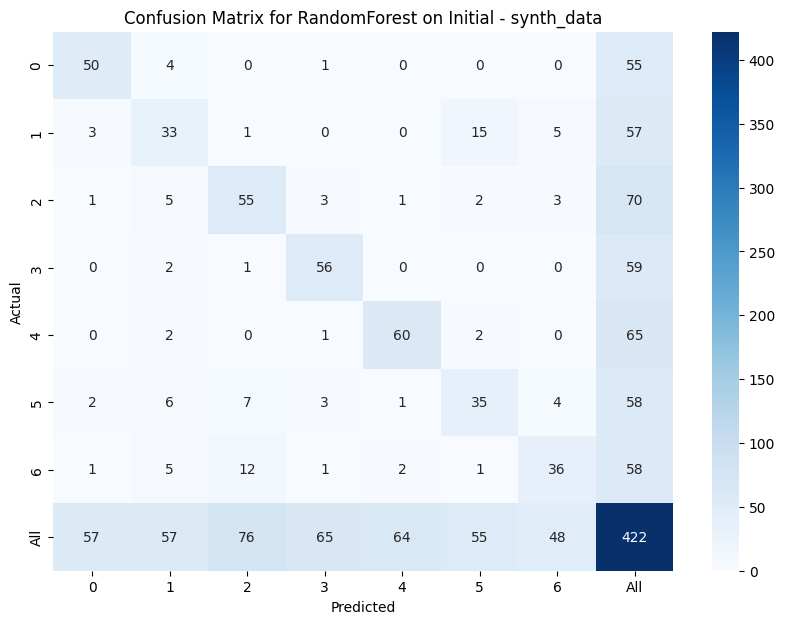

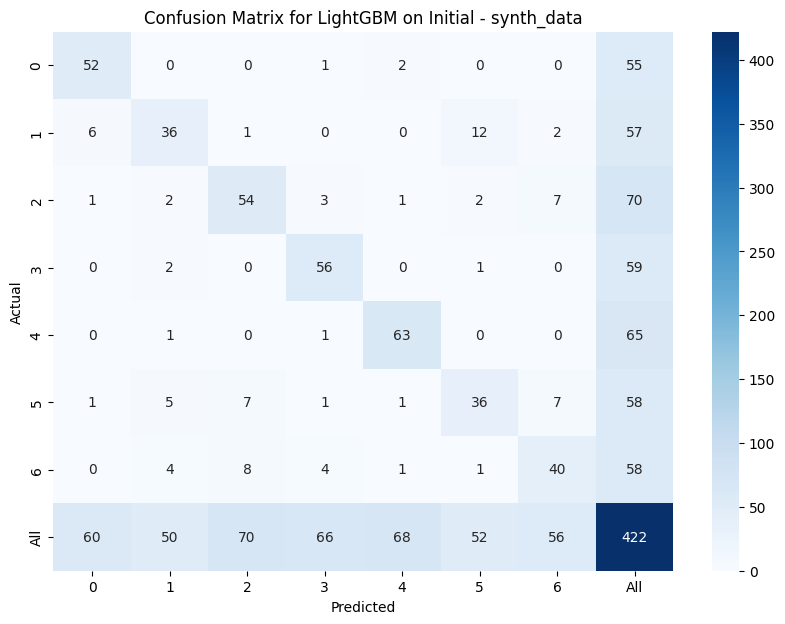

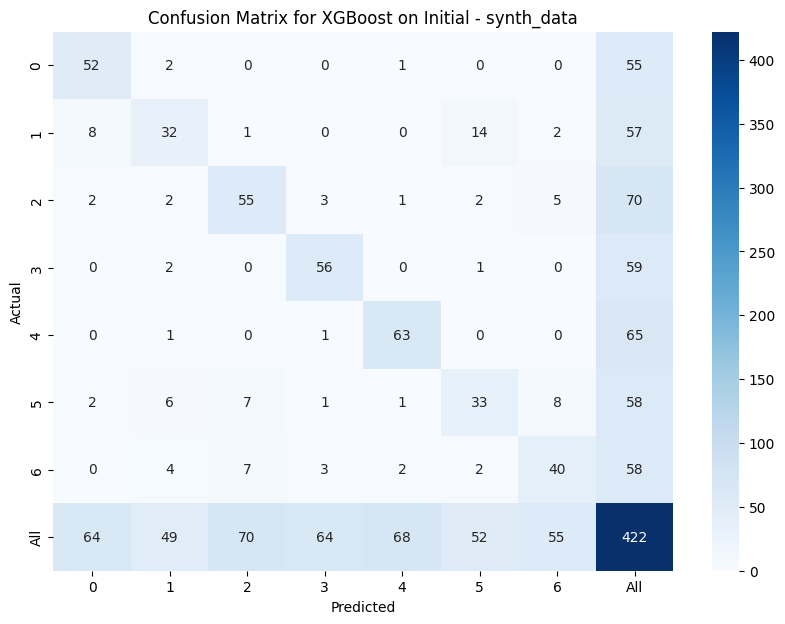

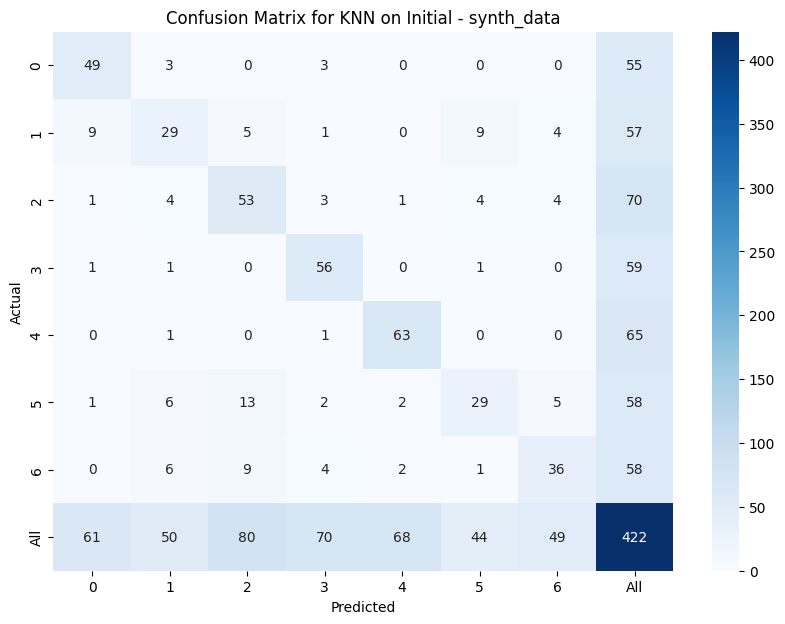

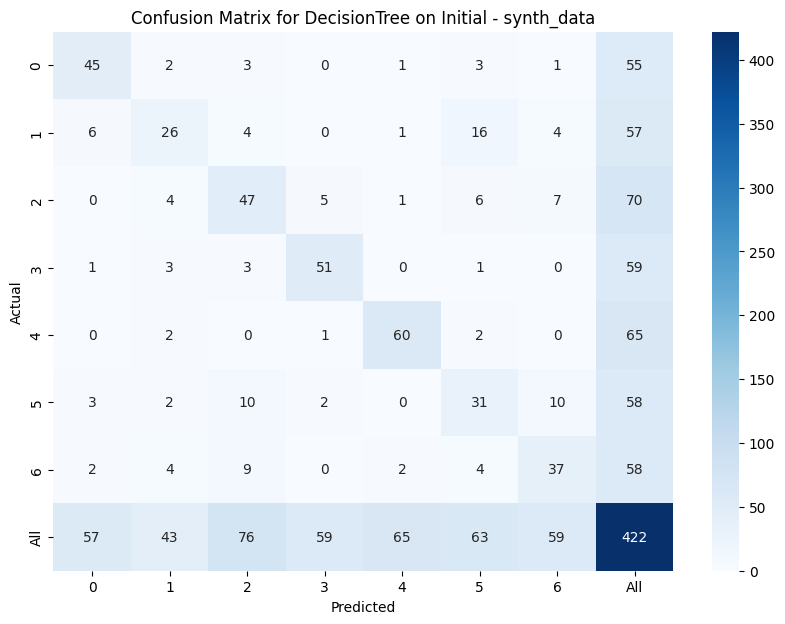

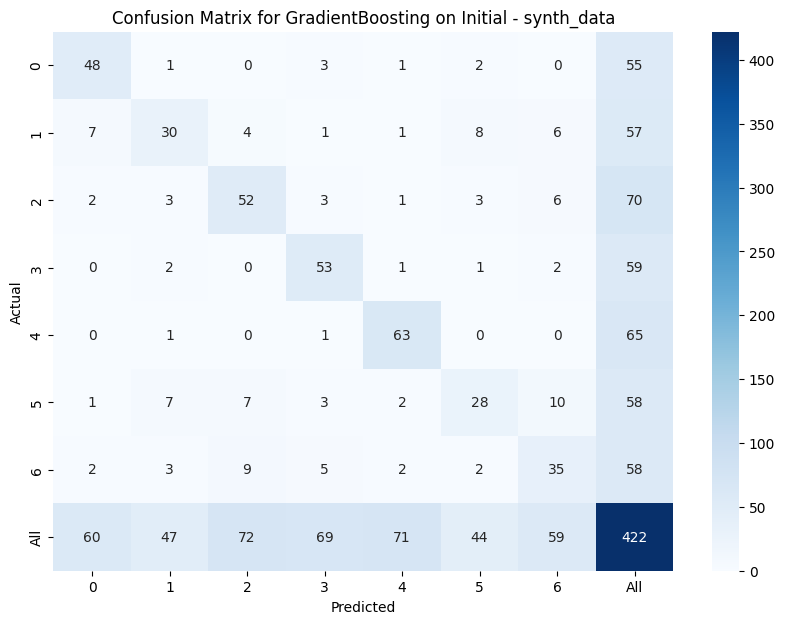

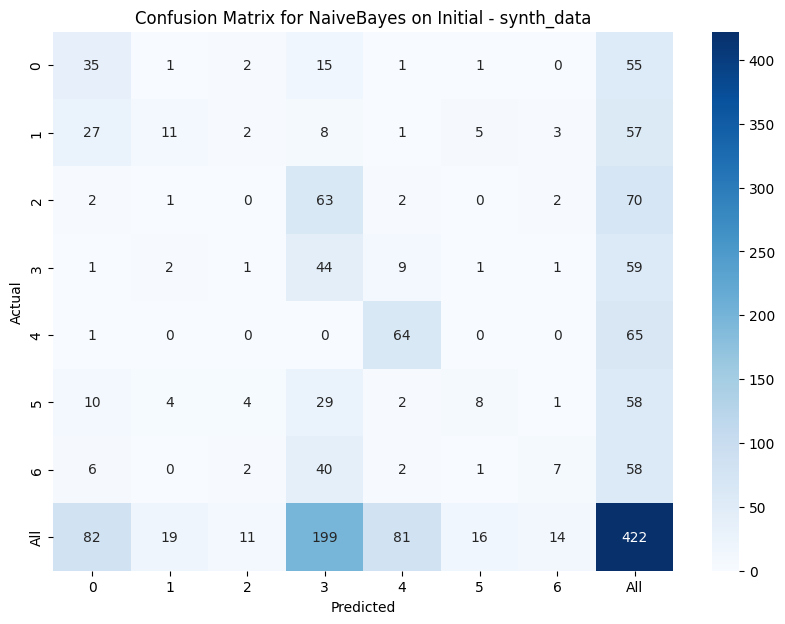

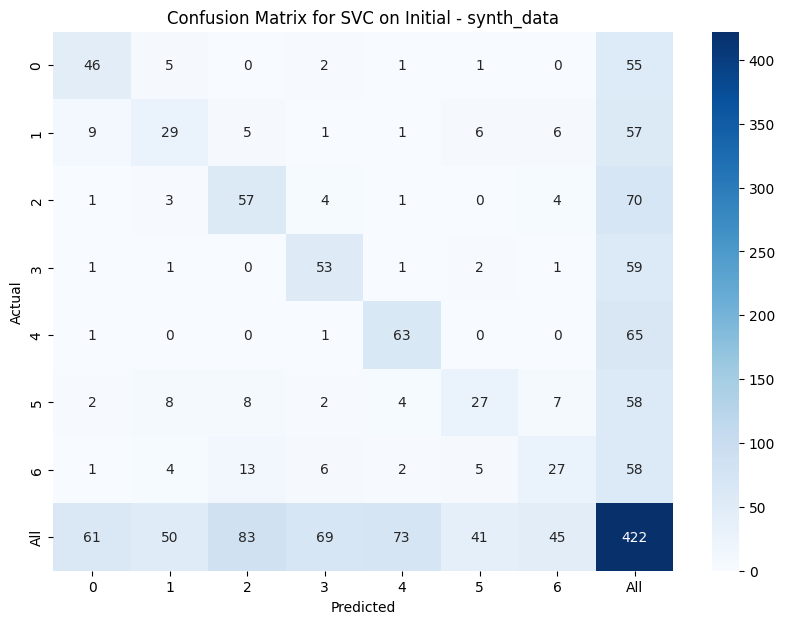

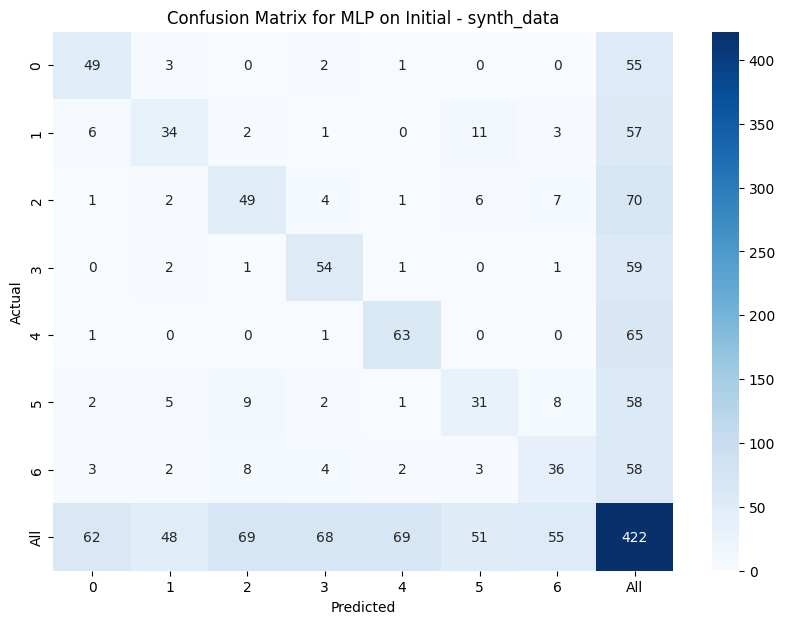

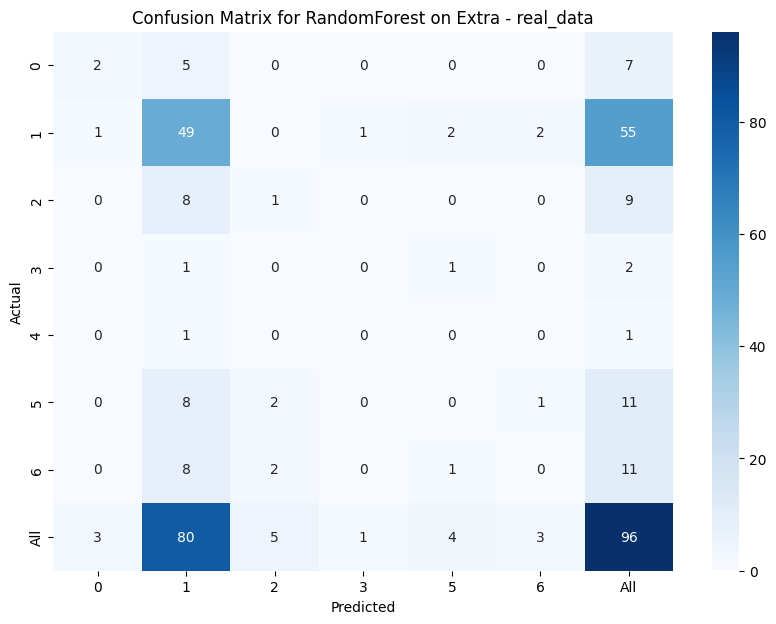

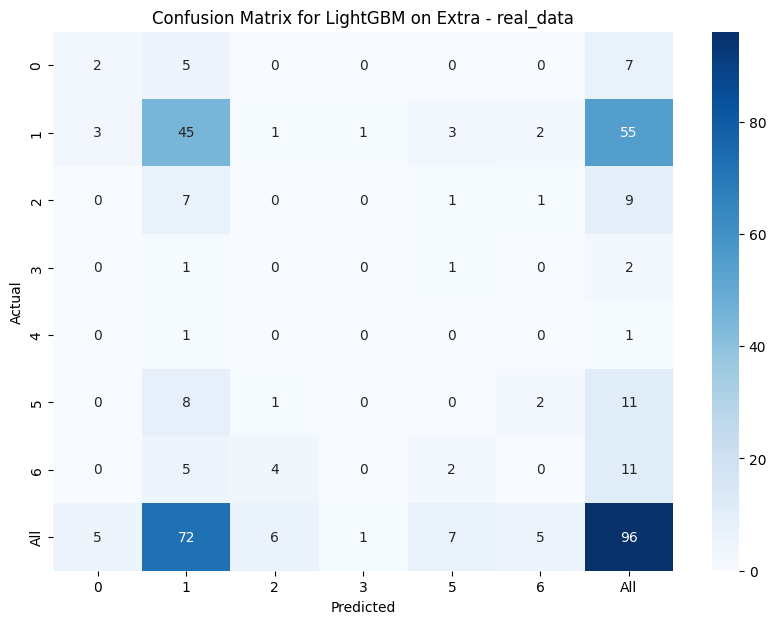

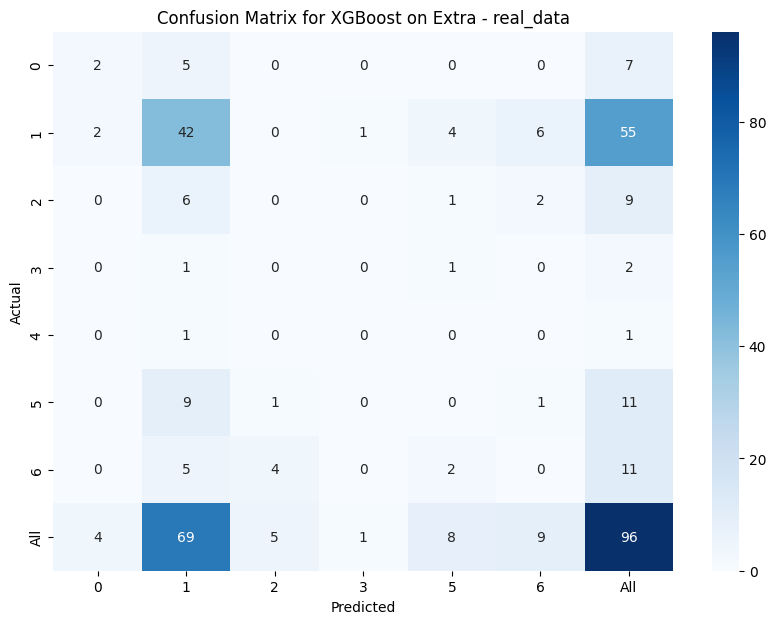

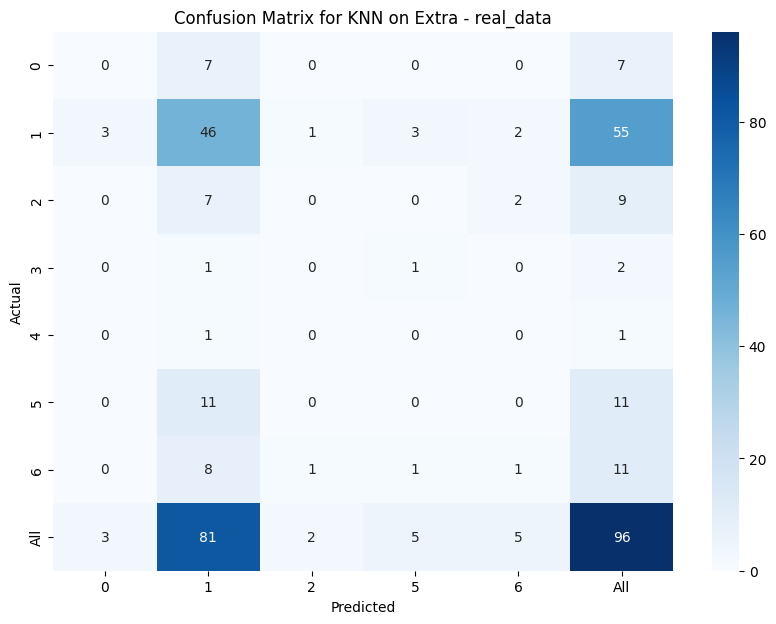

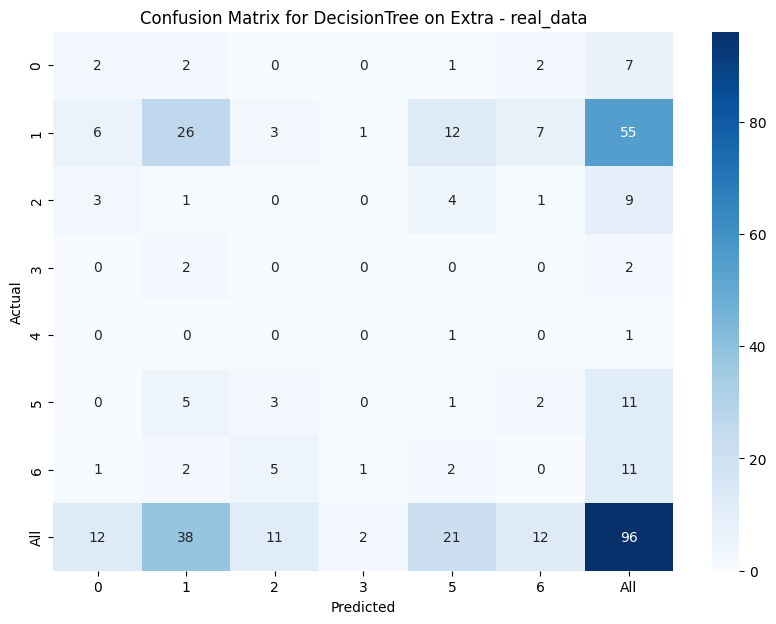

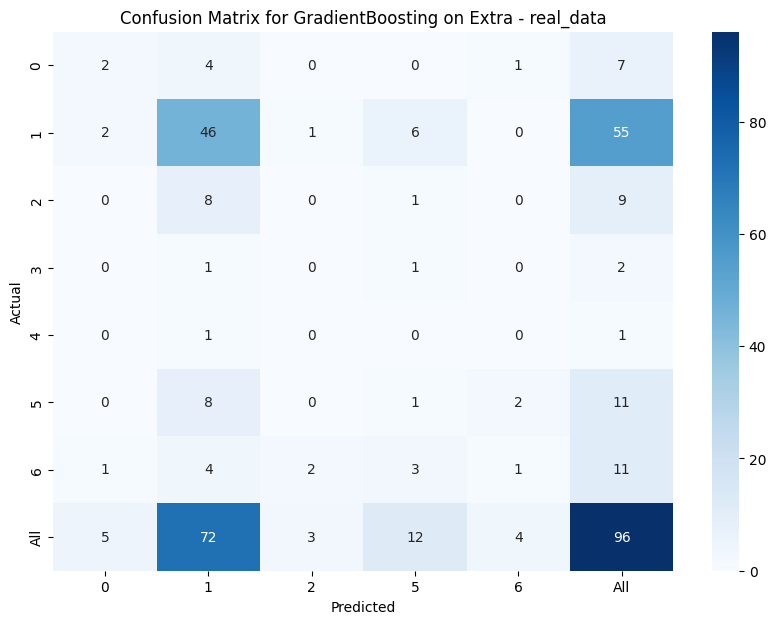

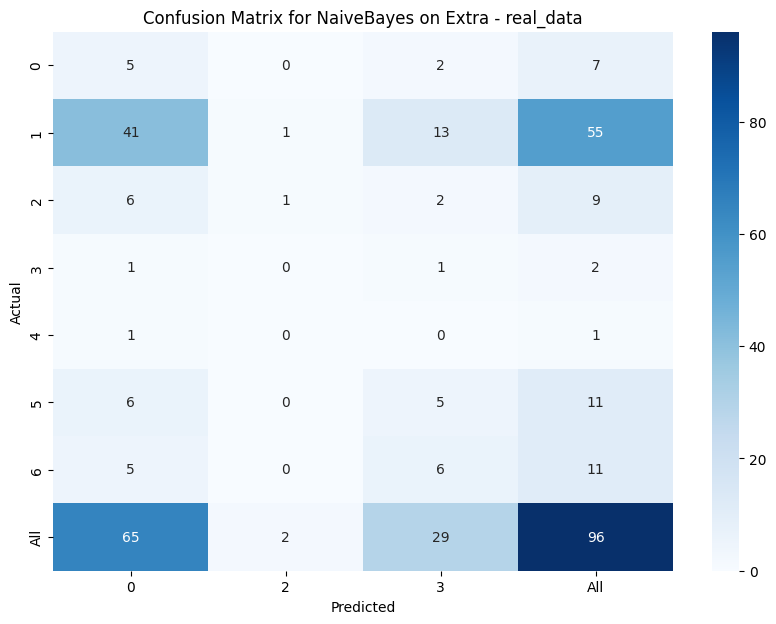

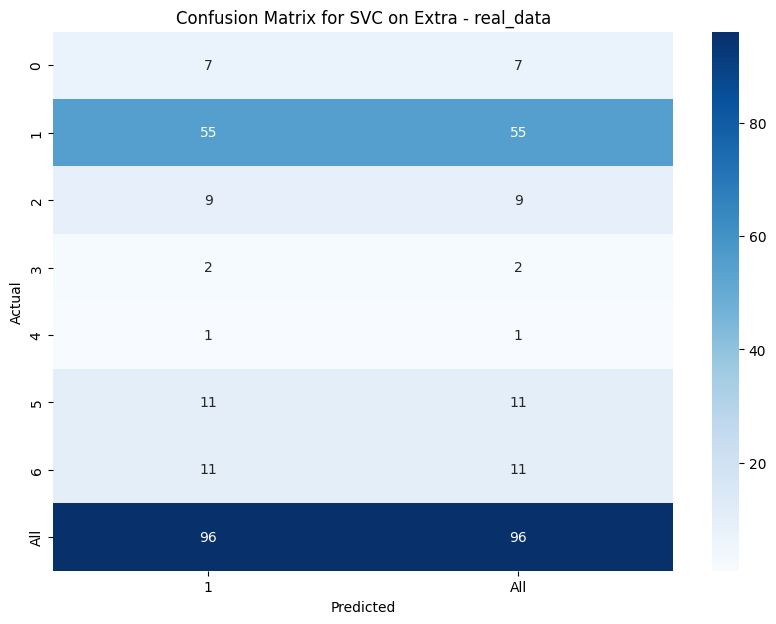

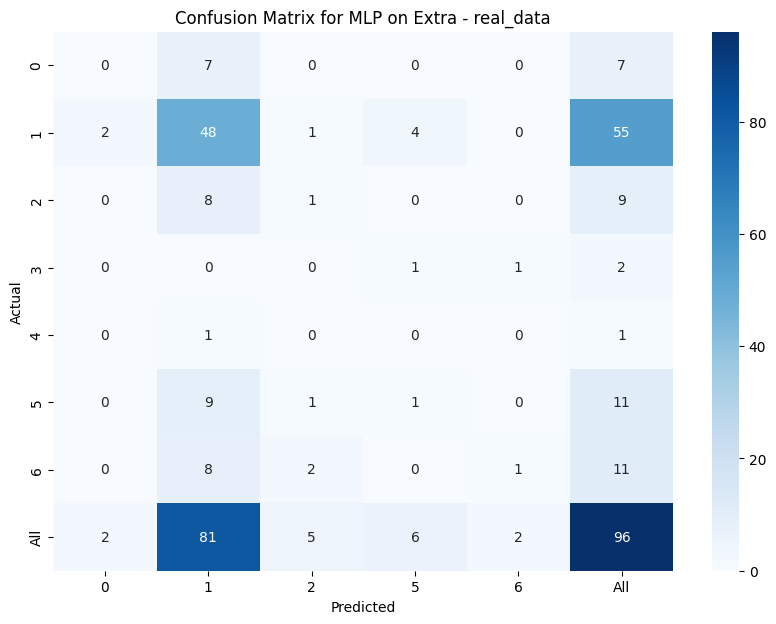

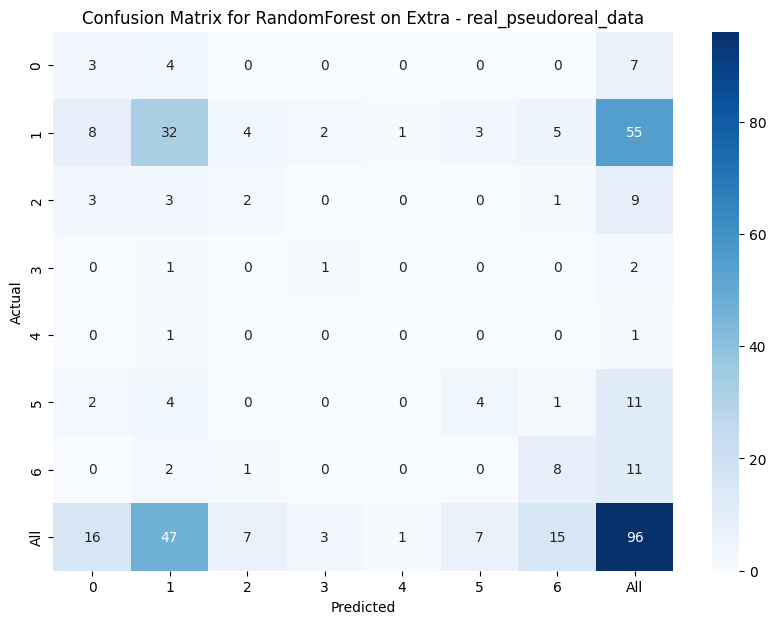

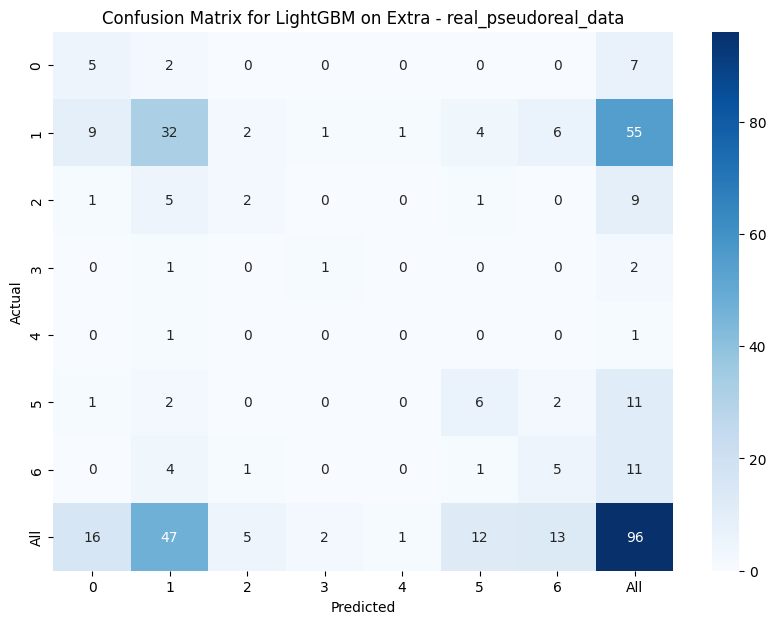

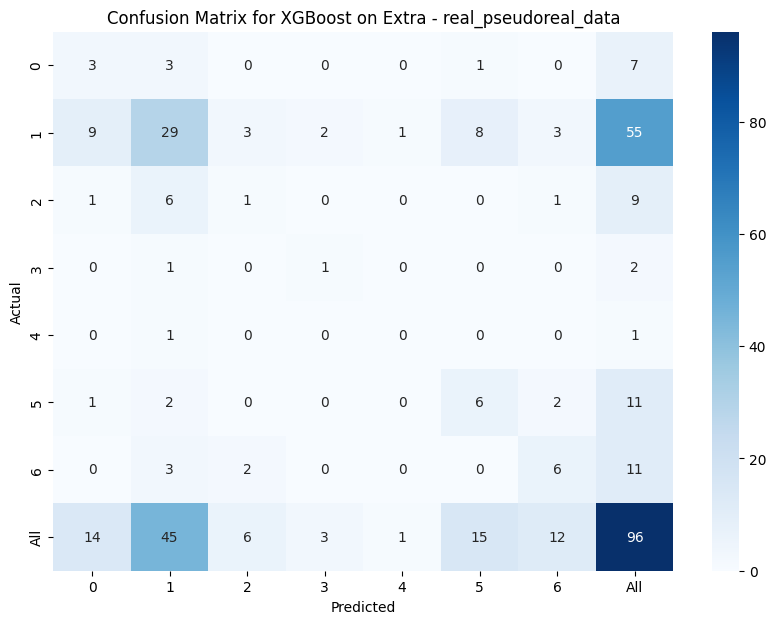

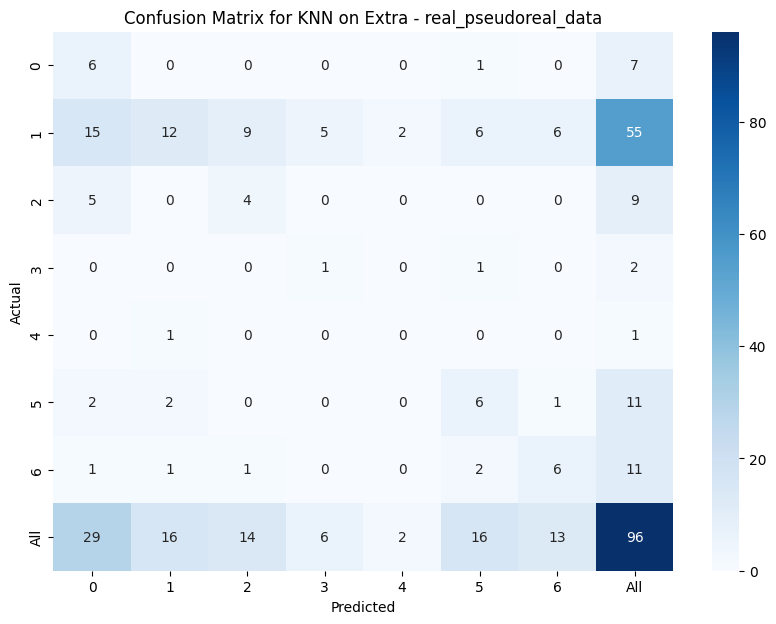

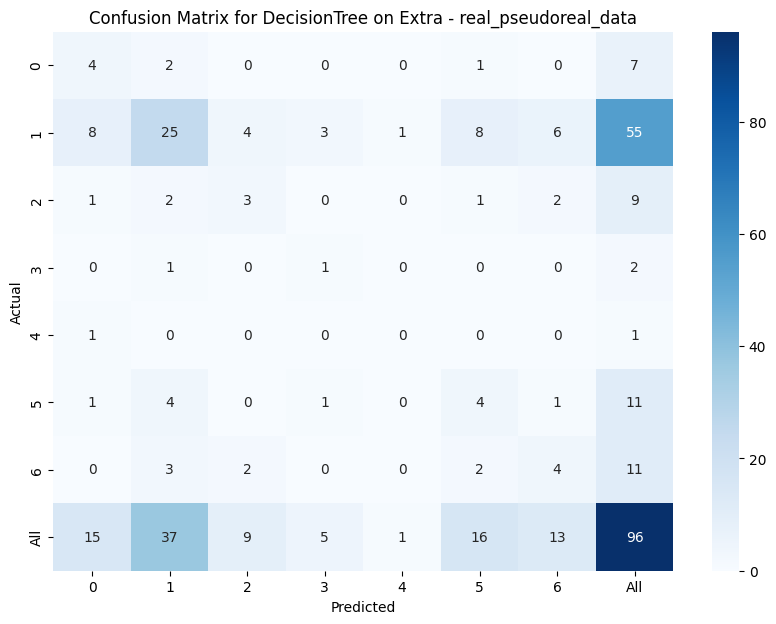

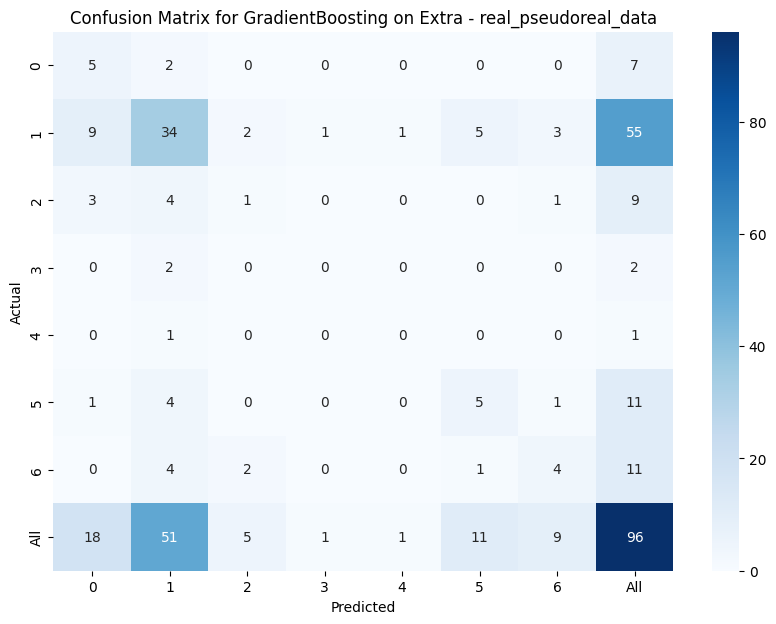

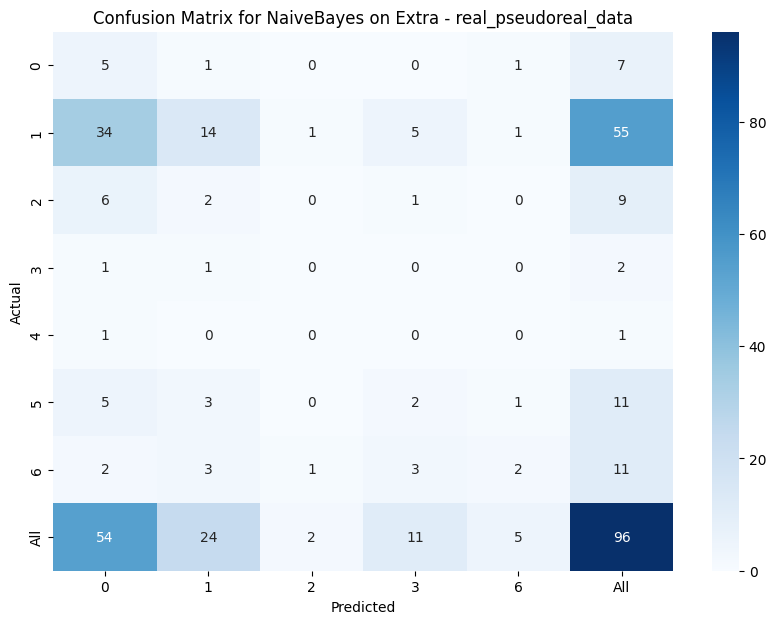

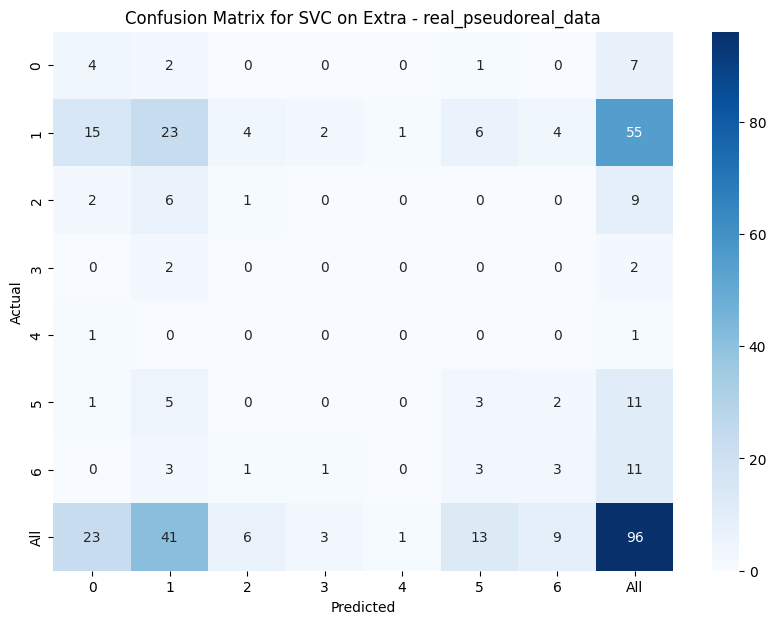

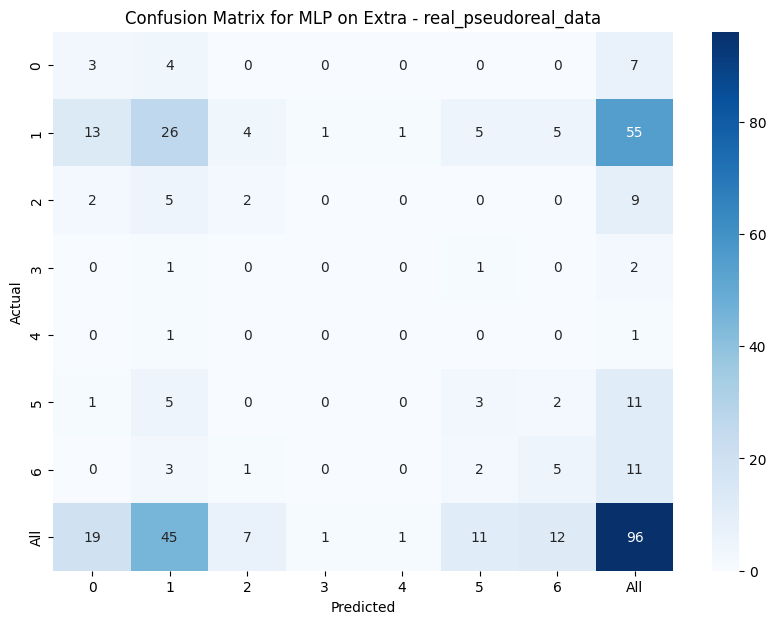

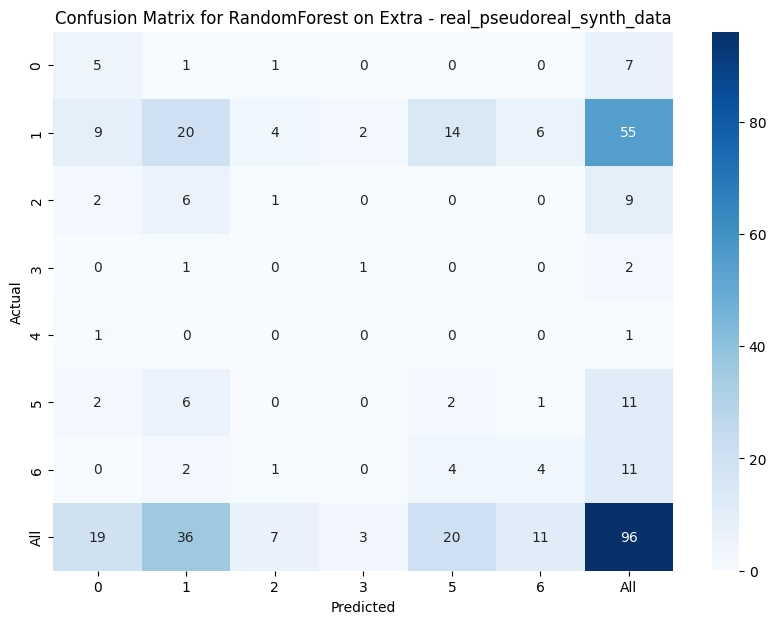

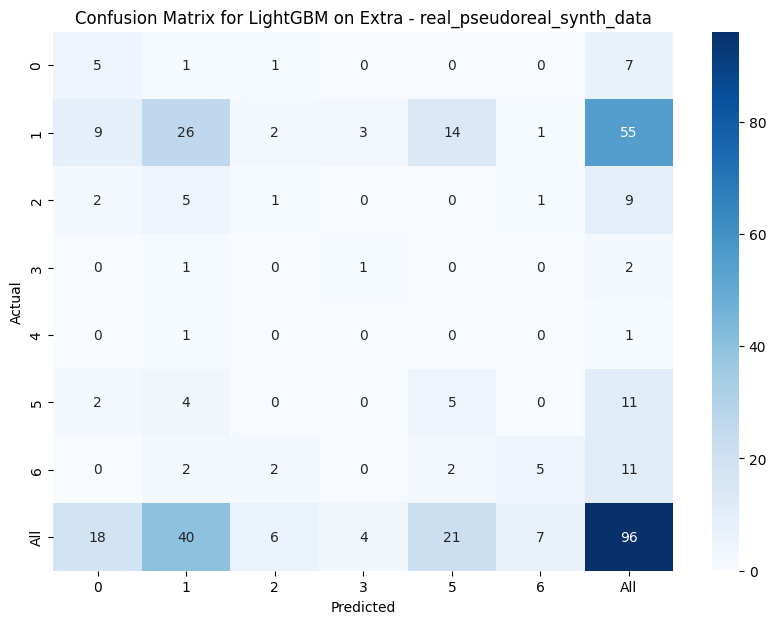

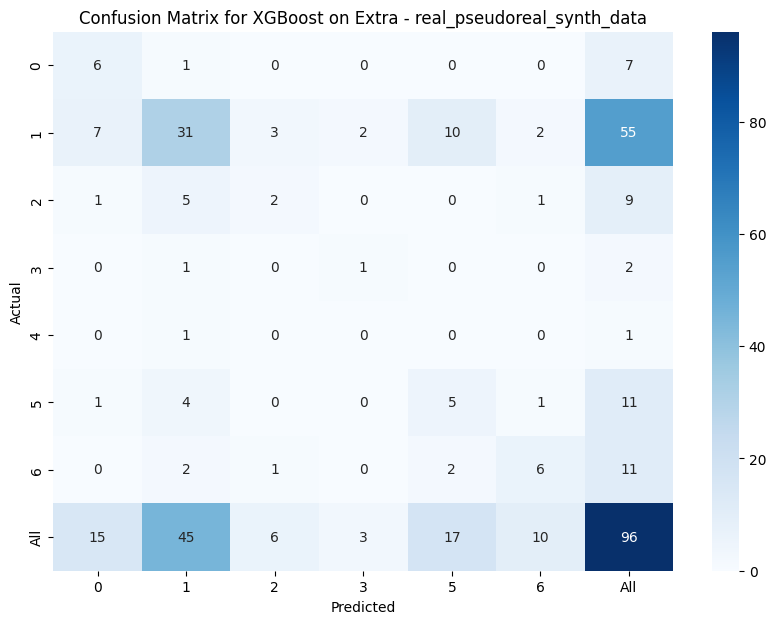

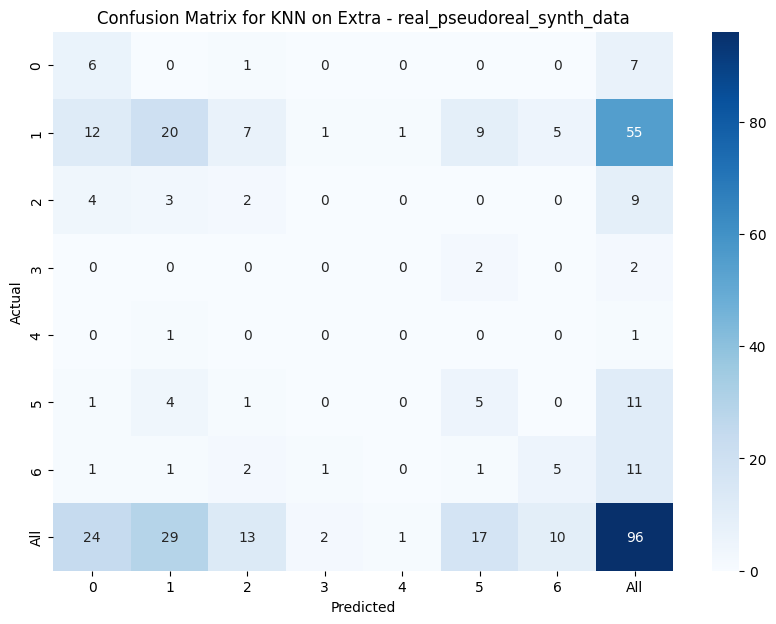

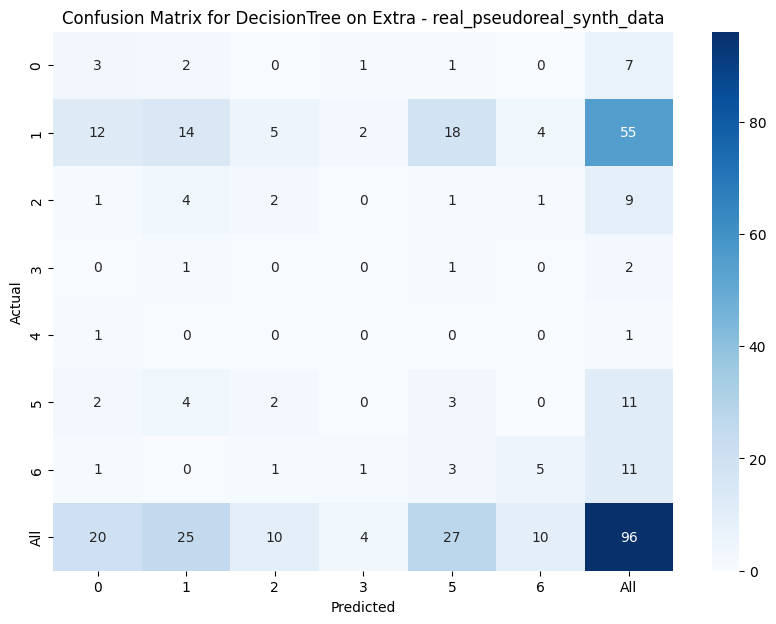

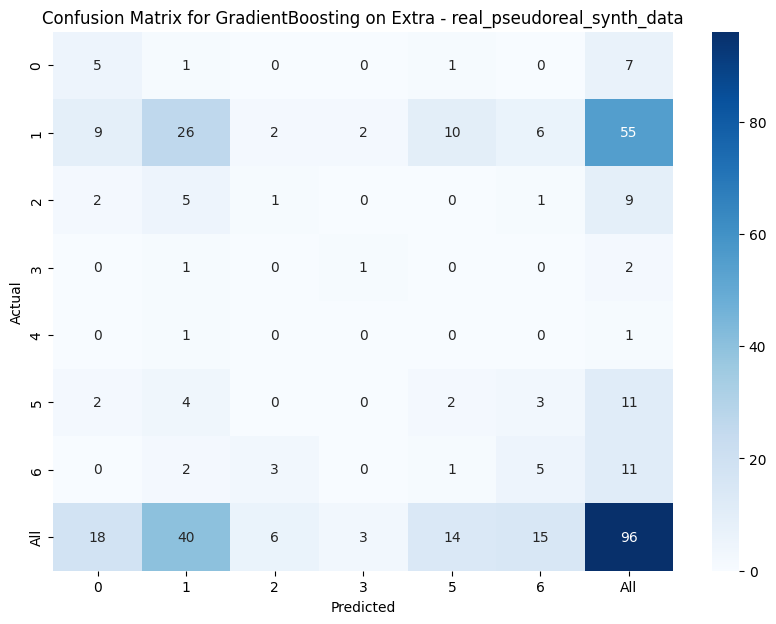

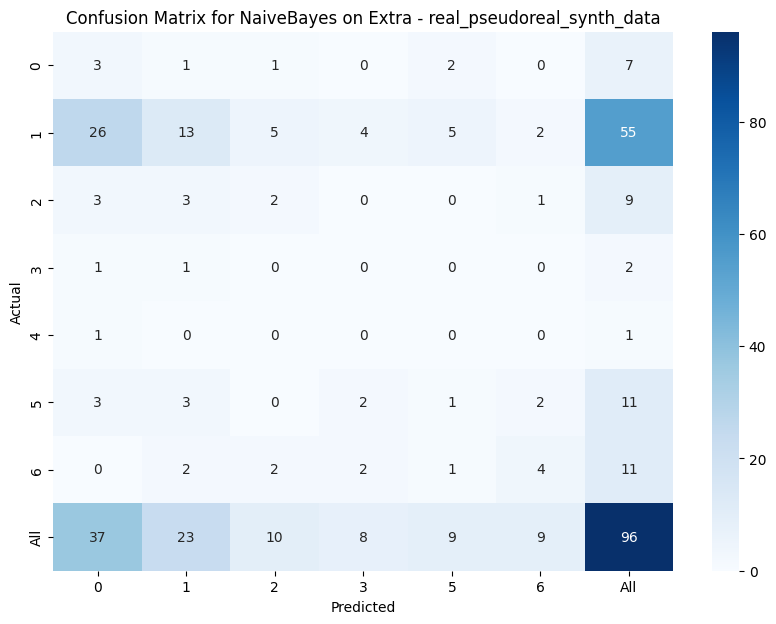

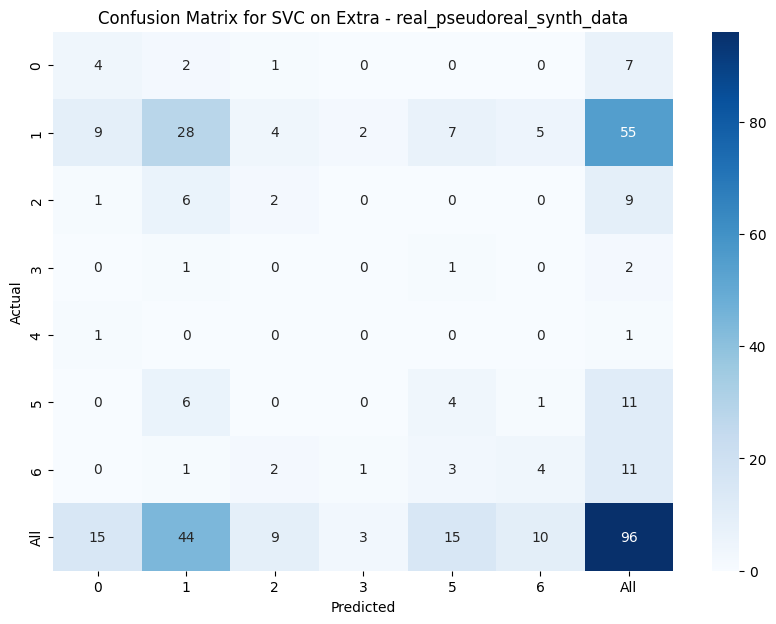

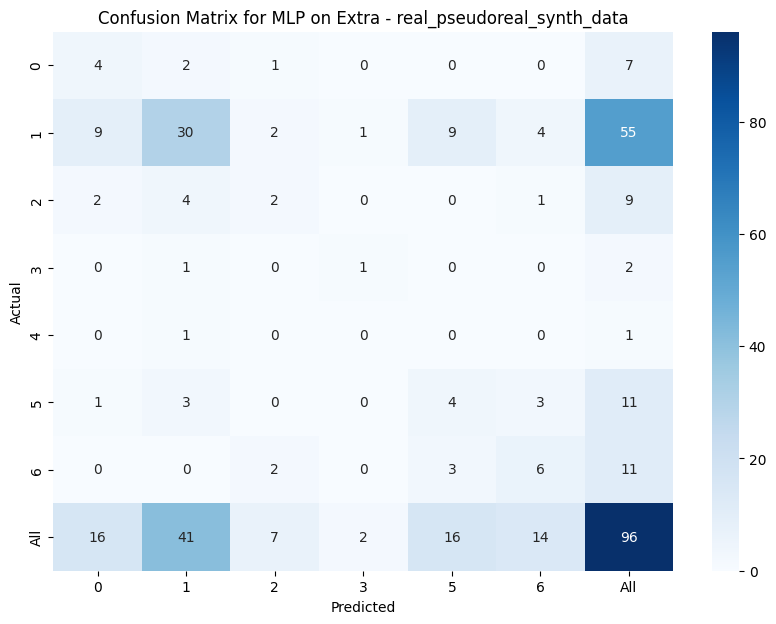

In [4]:
# Plot the confusion matrices
for (approach, dataset, model_name), cm_df in cm.items():
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix for {model_name} on {approach} - {dataset}")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

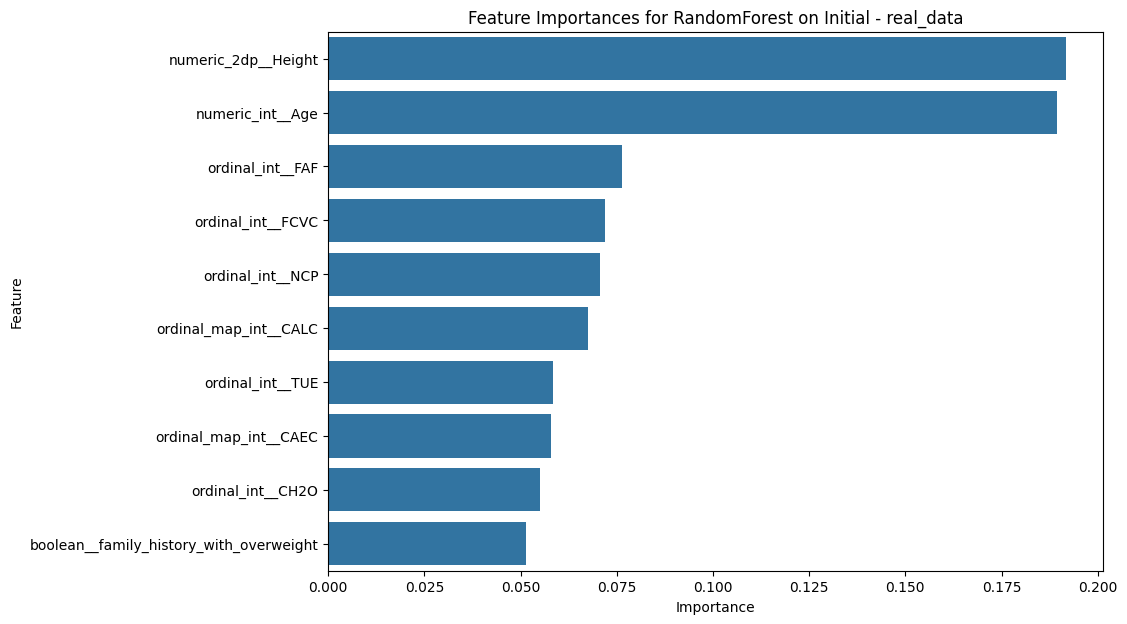

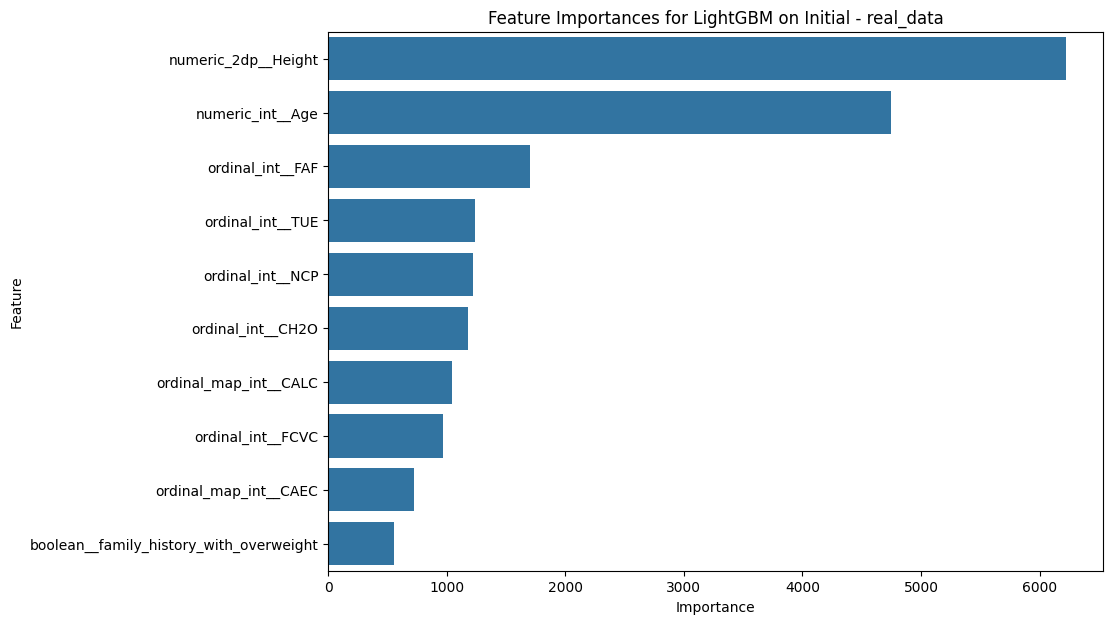

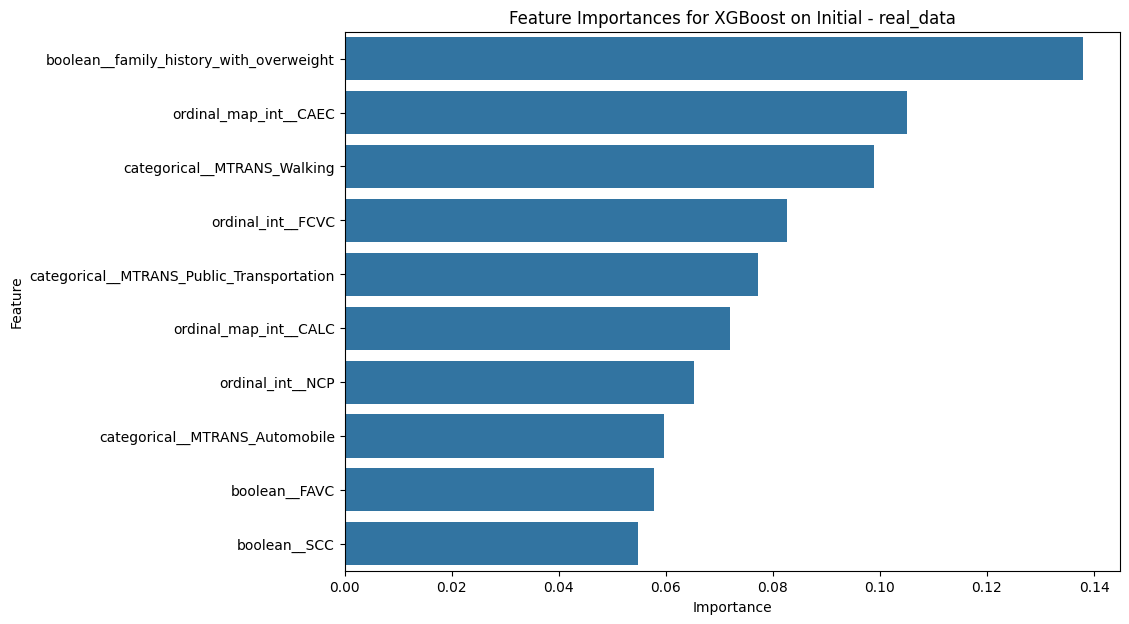

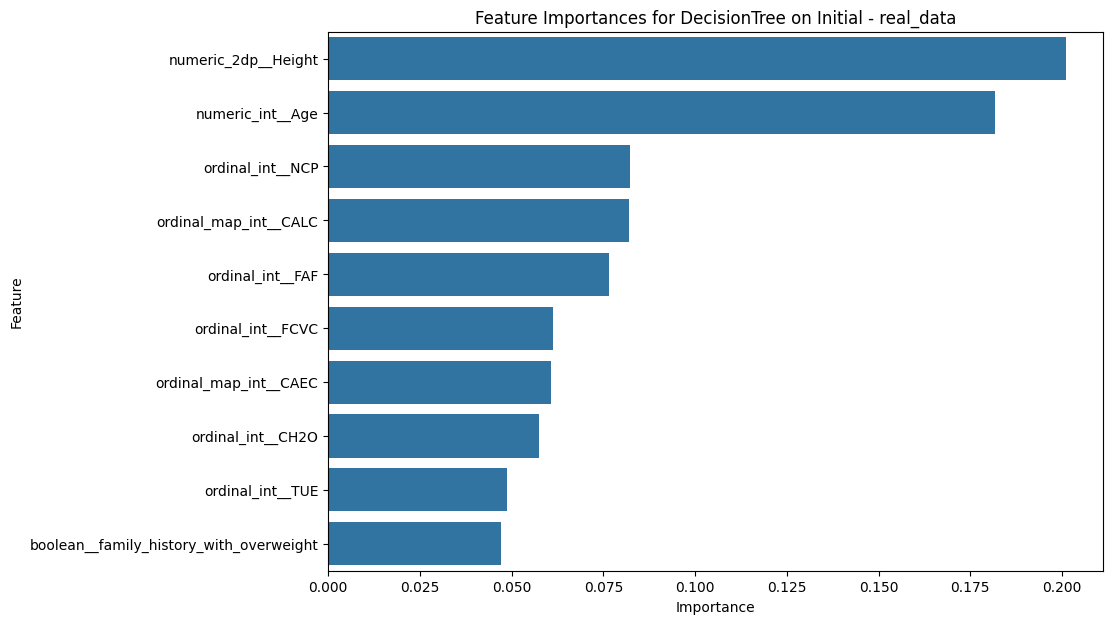

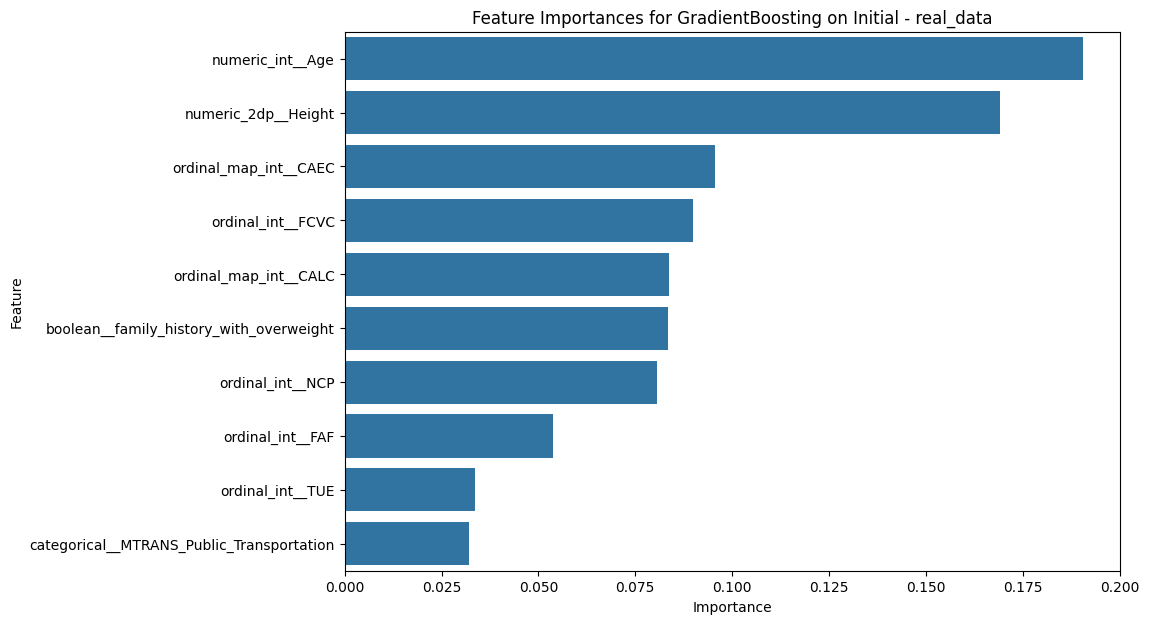

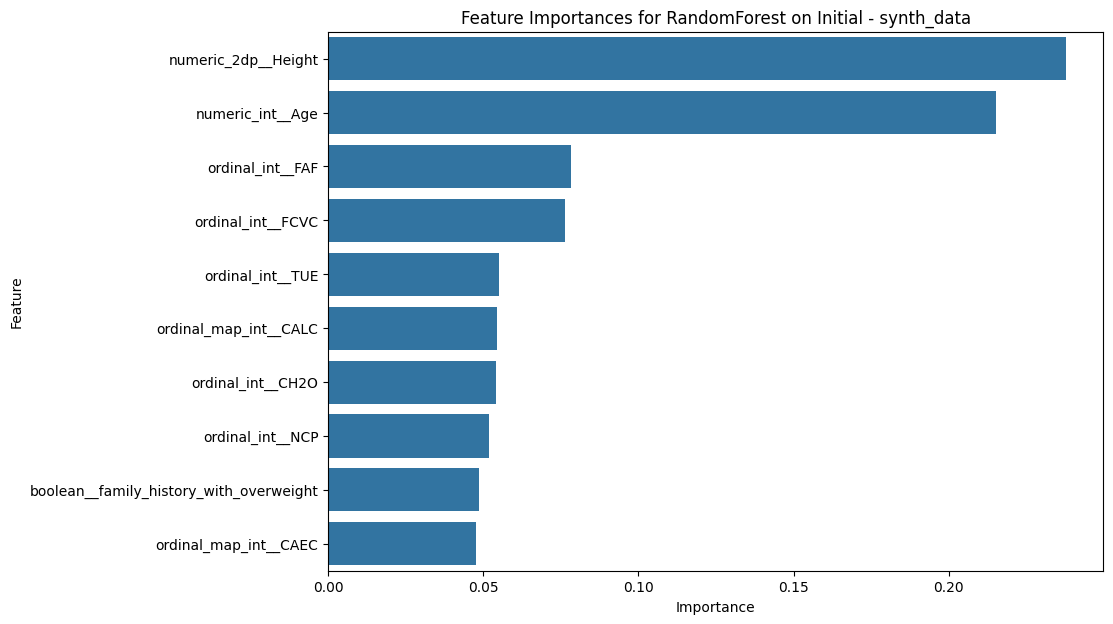

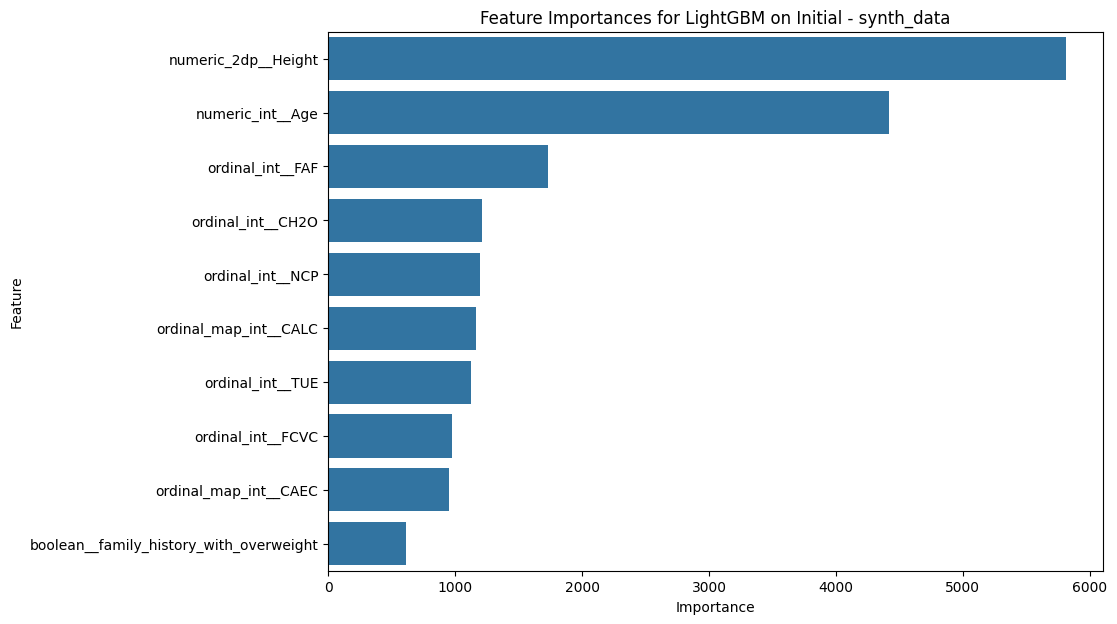

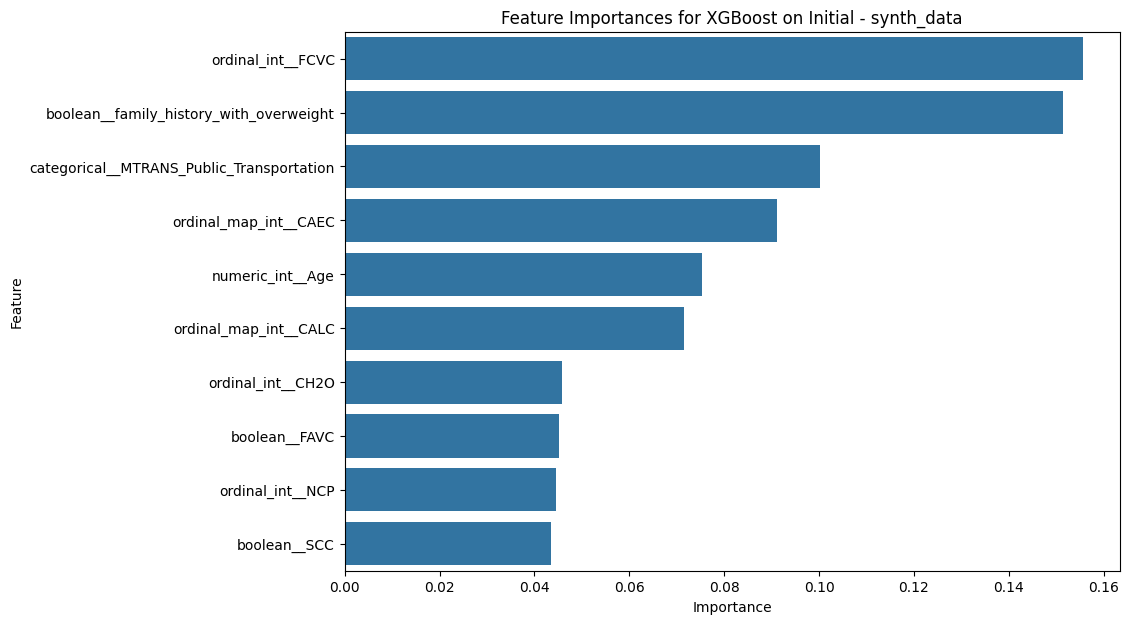

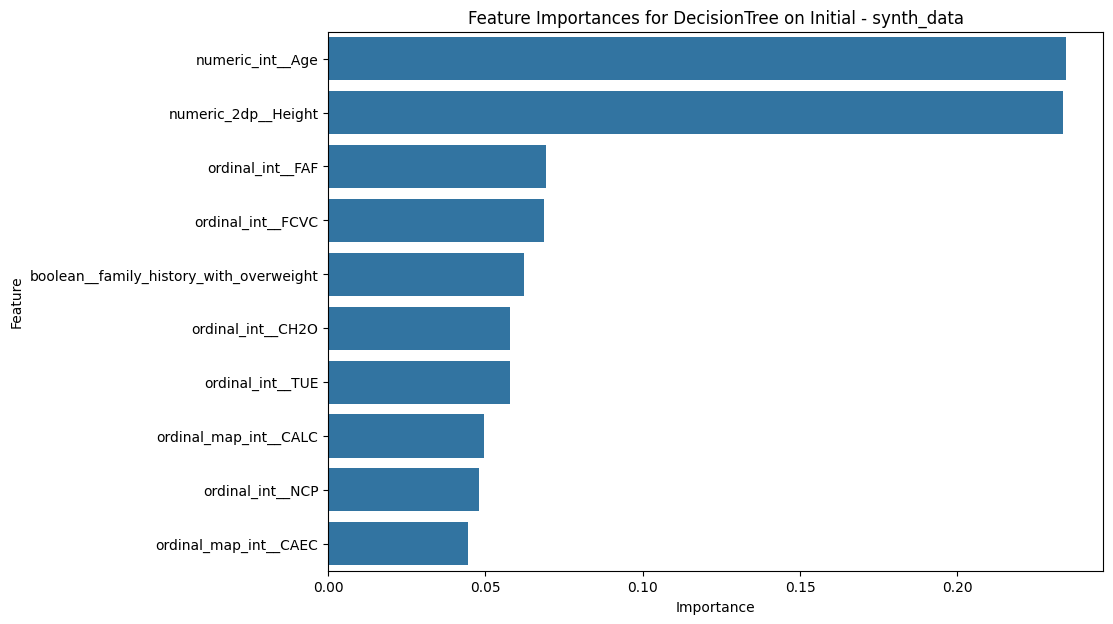

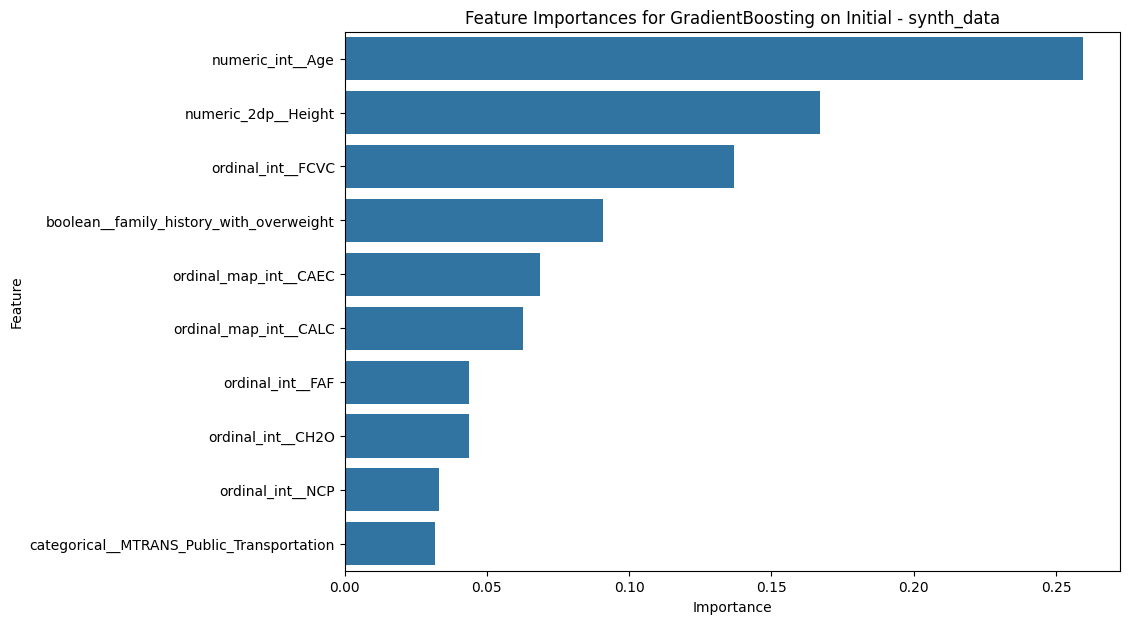

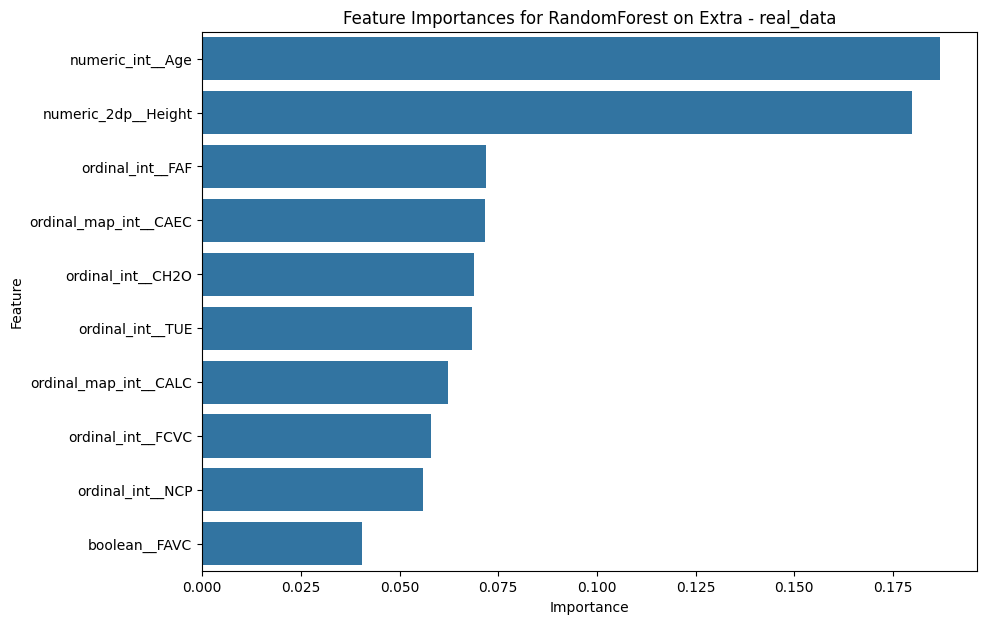

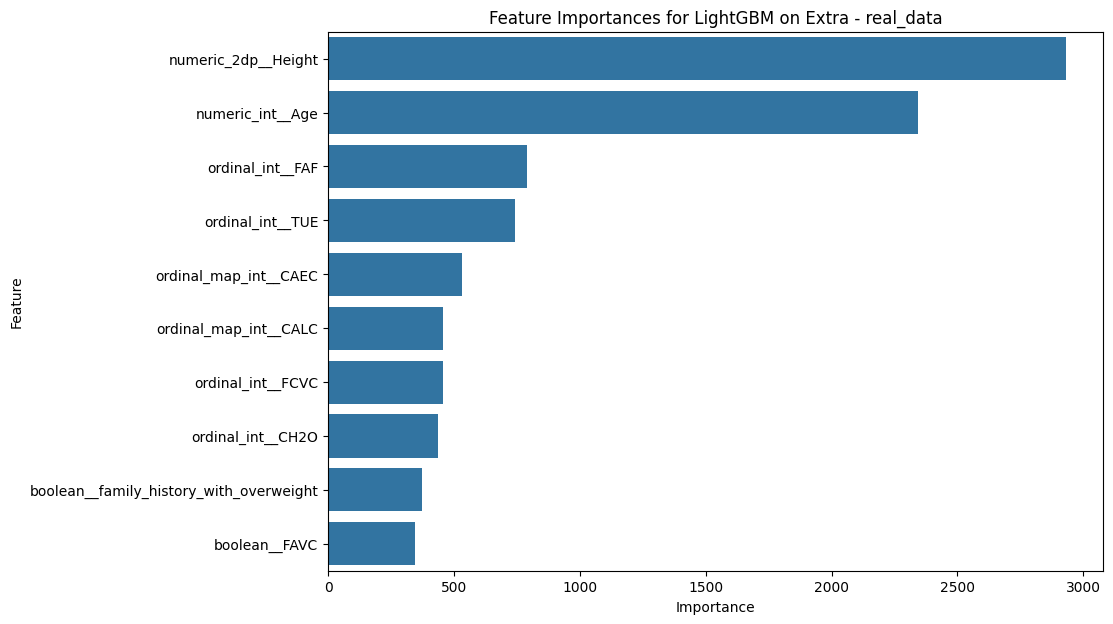

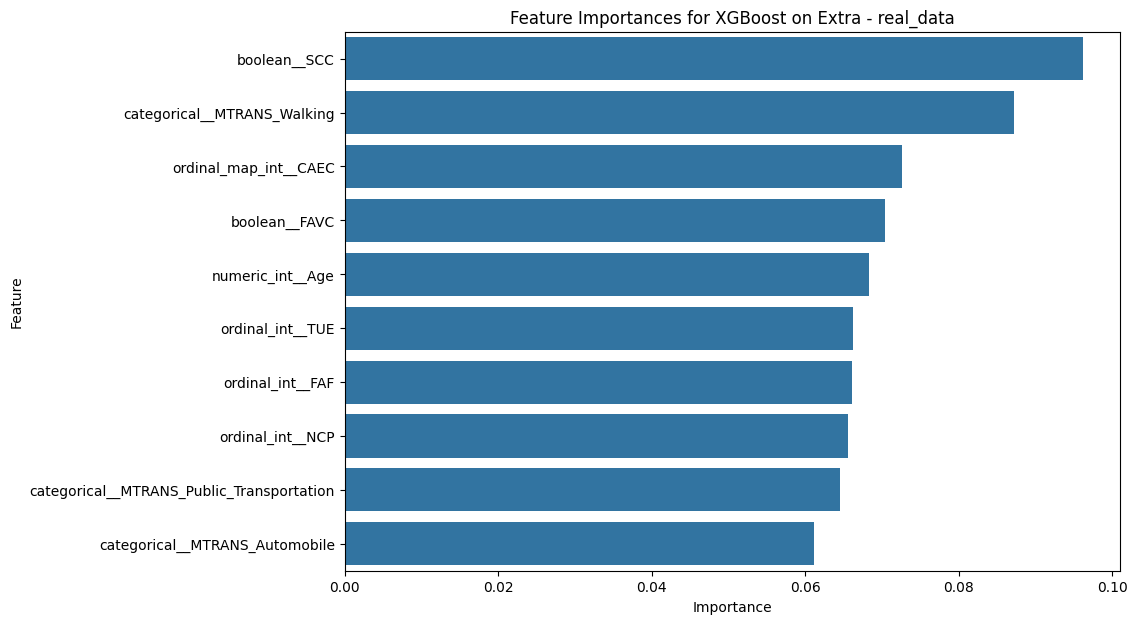

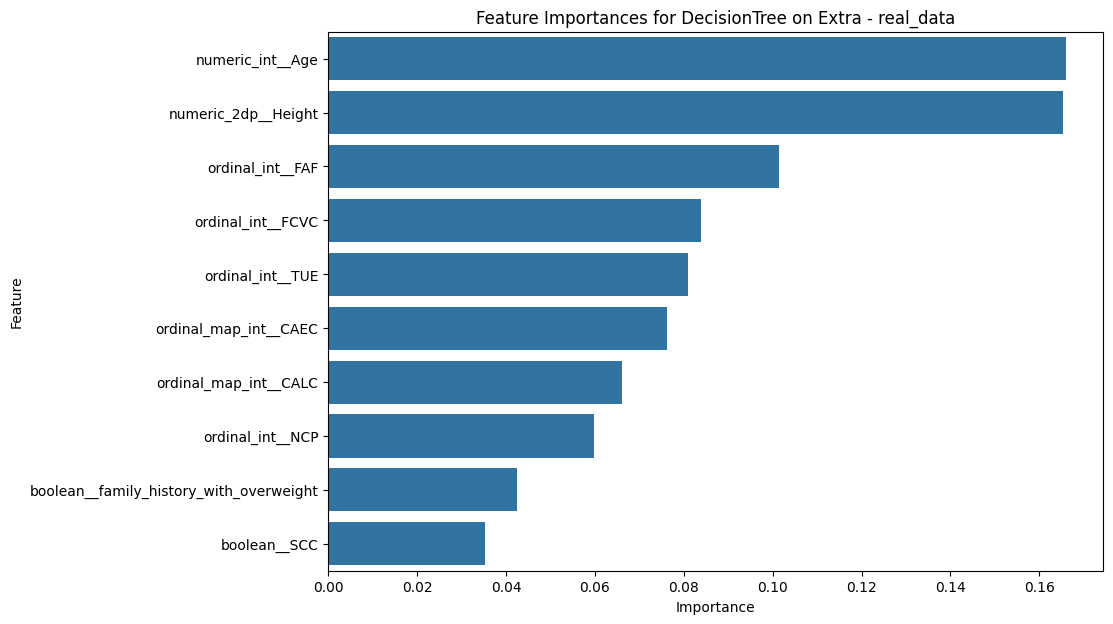

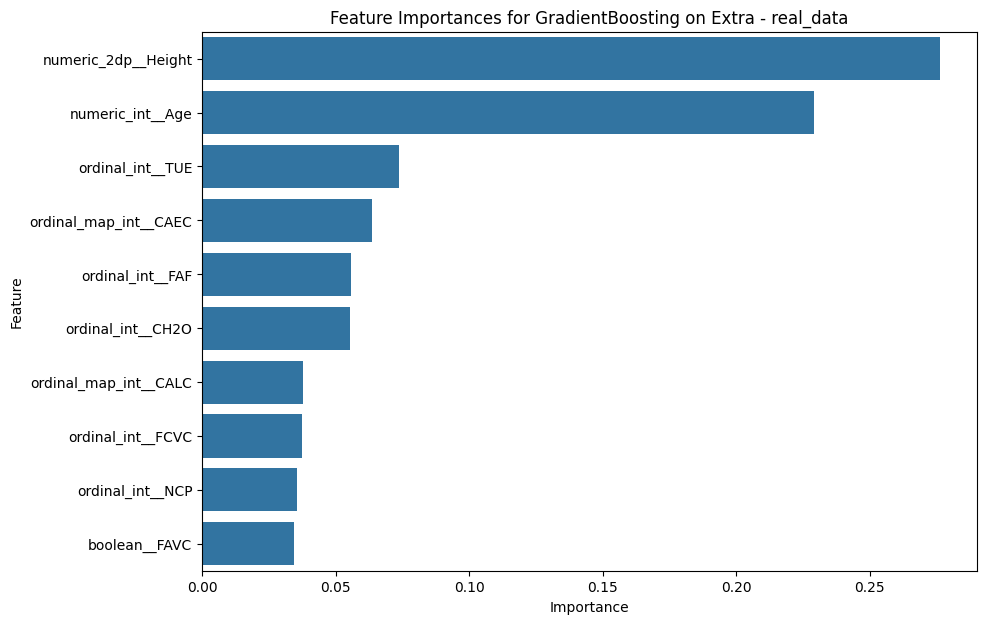

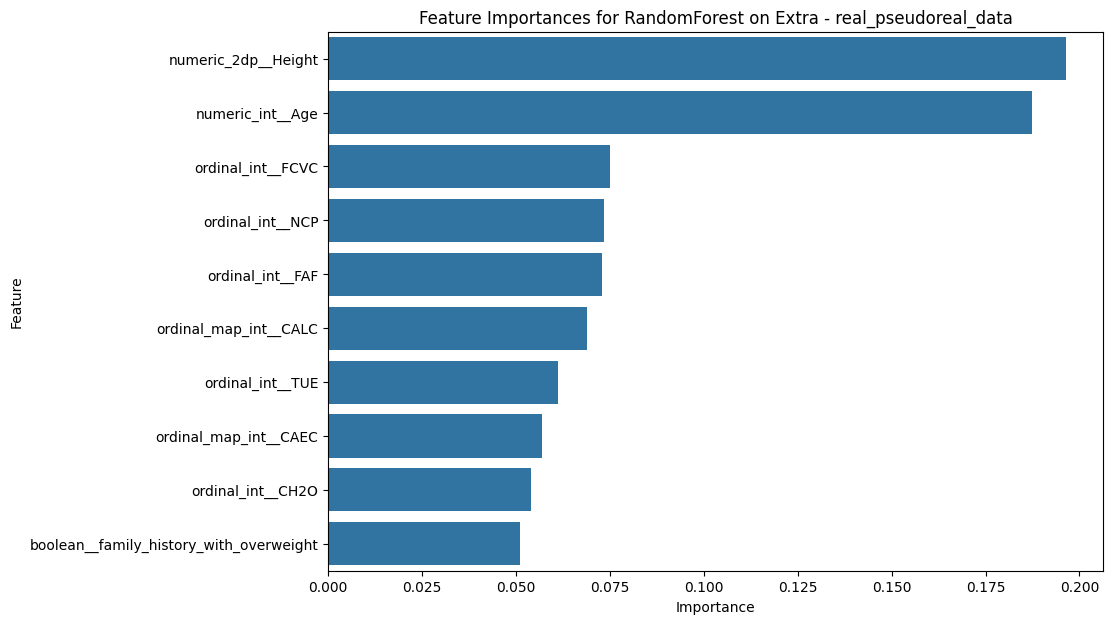

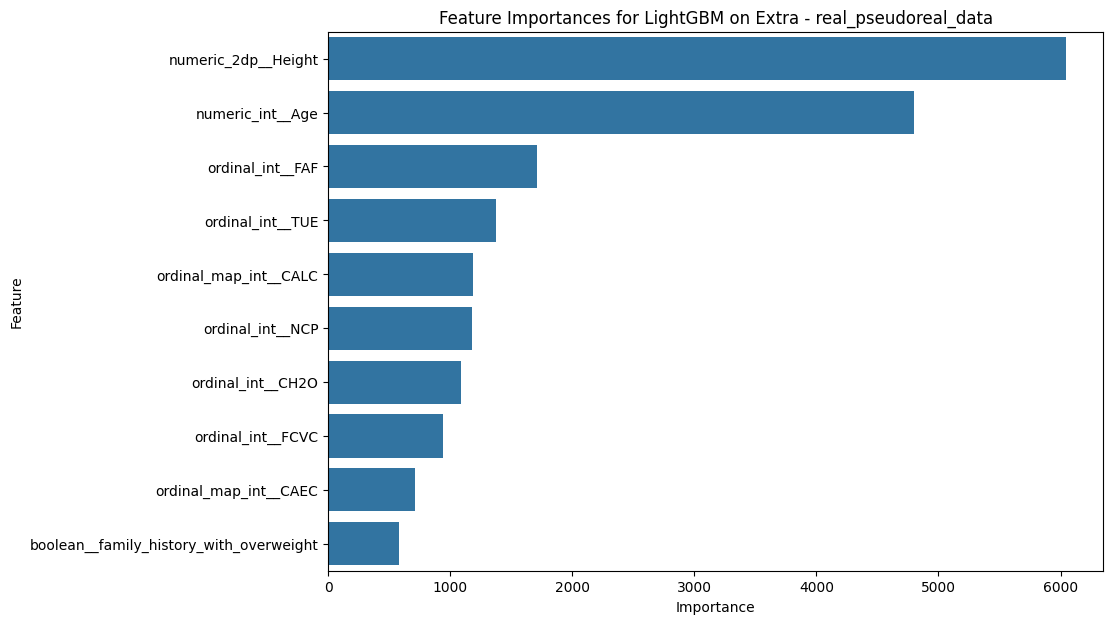

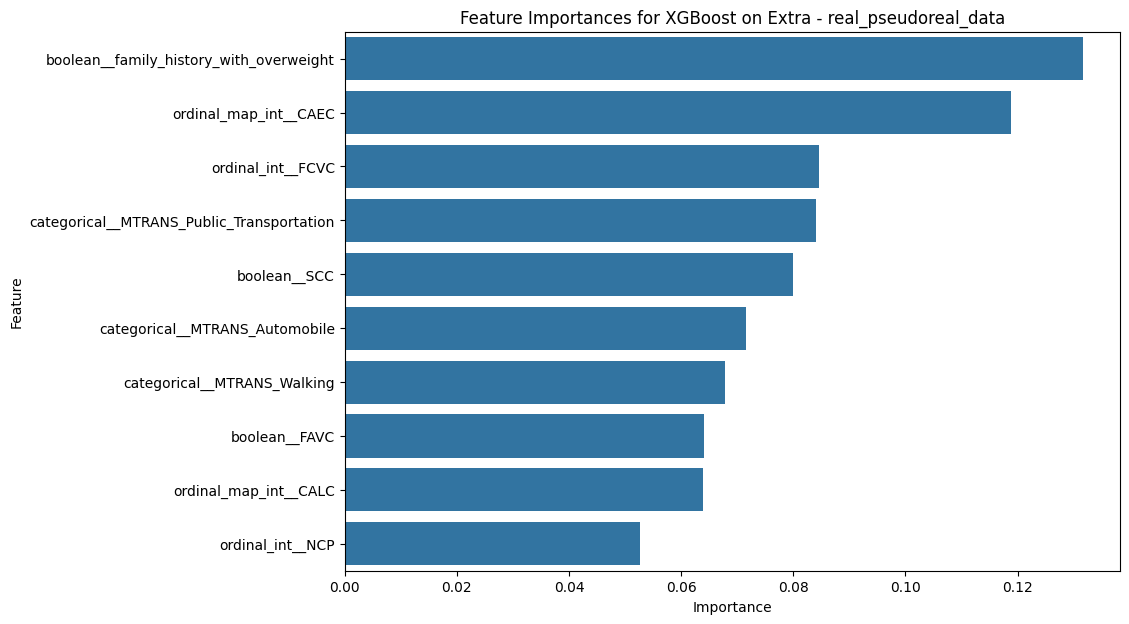

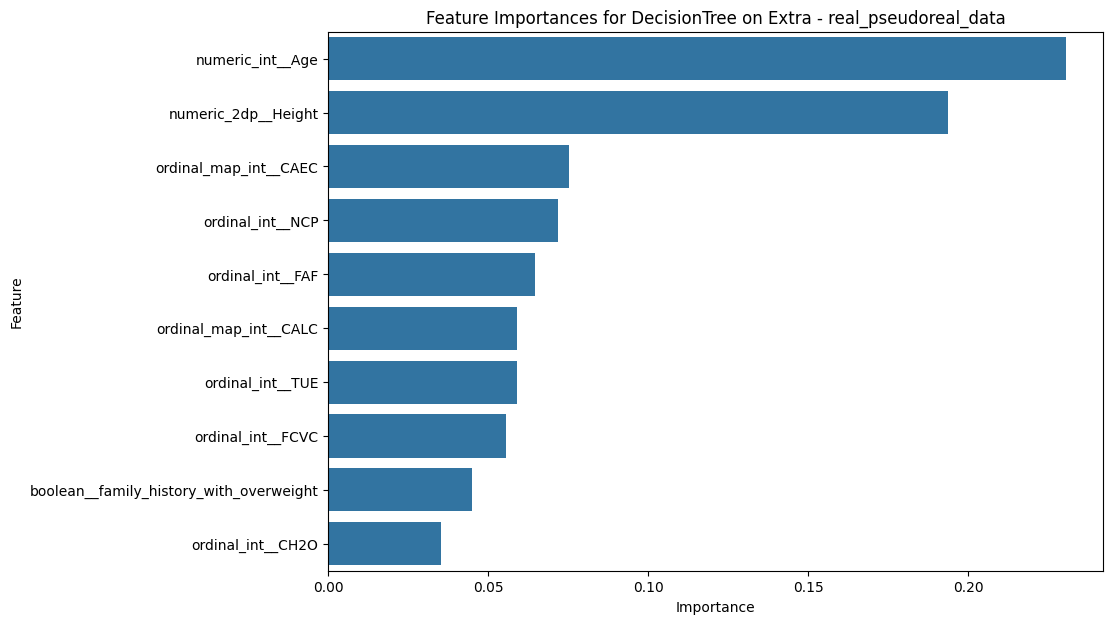

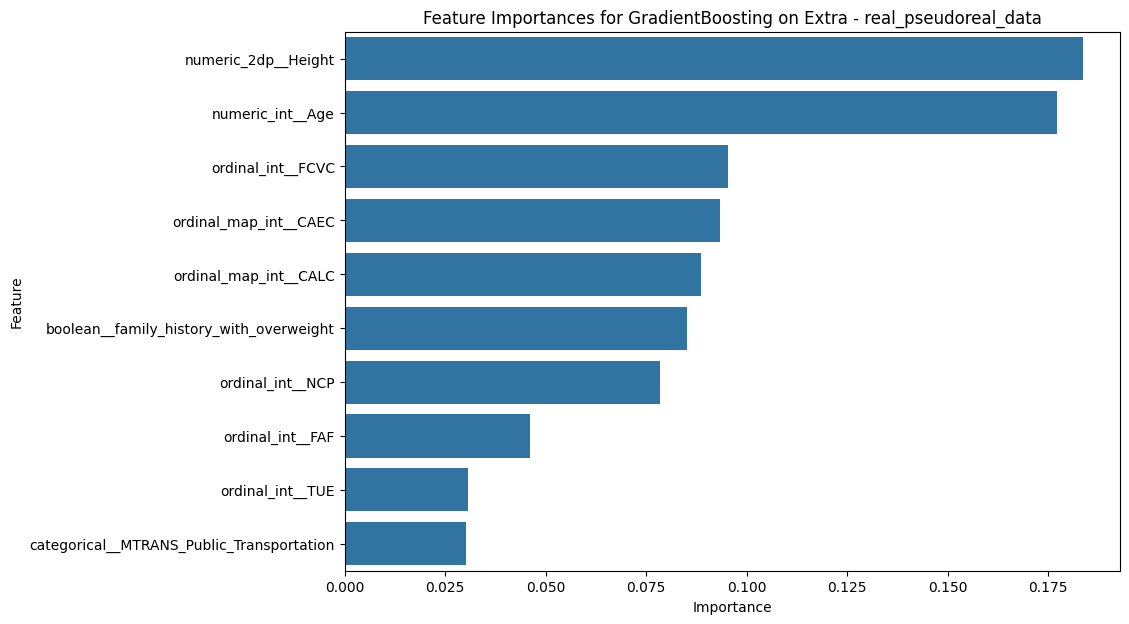

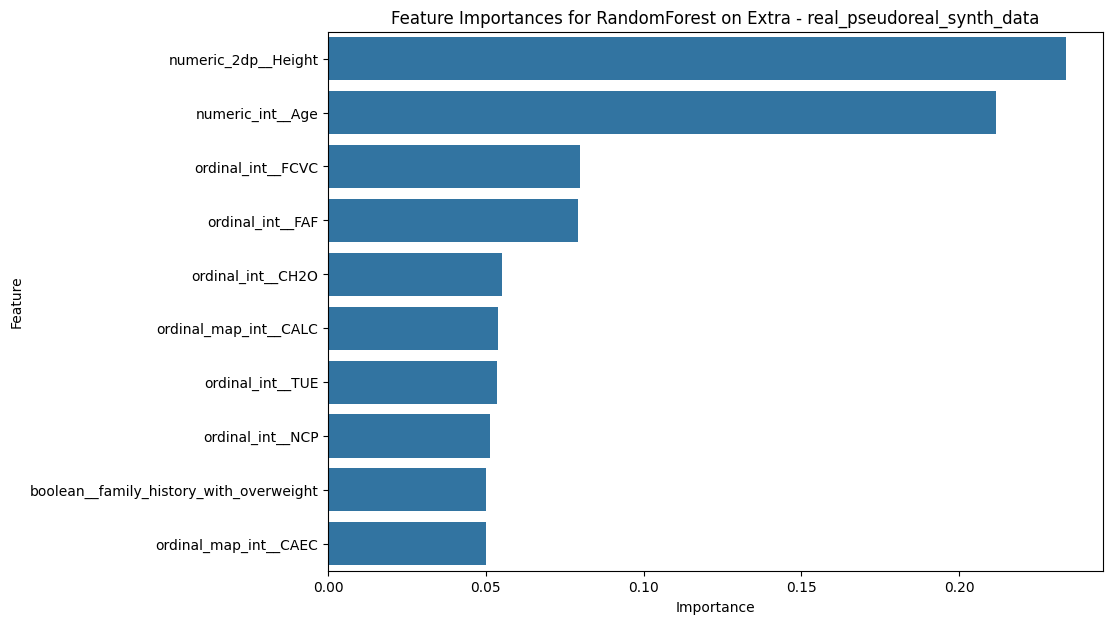

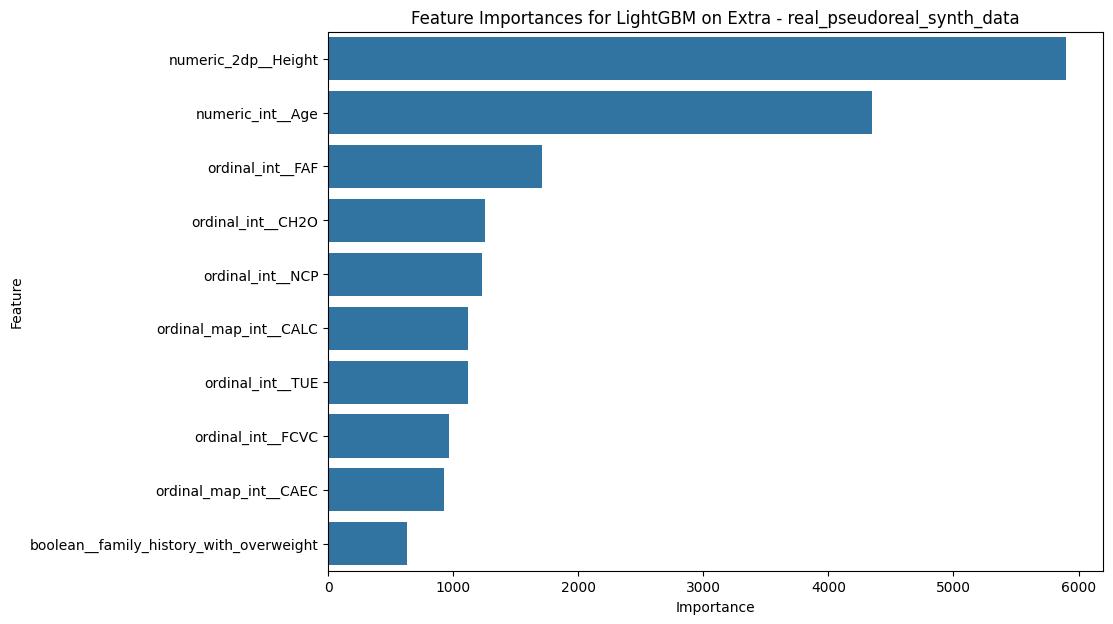

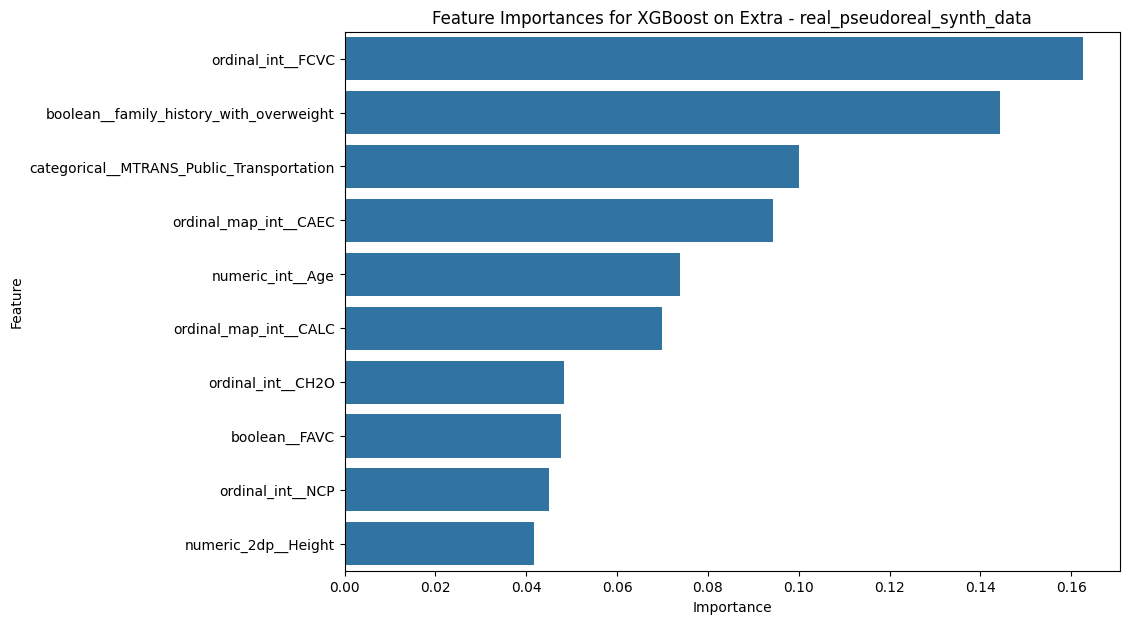

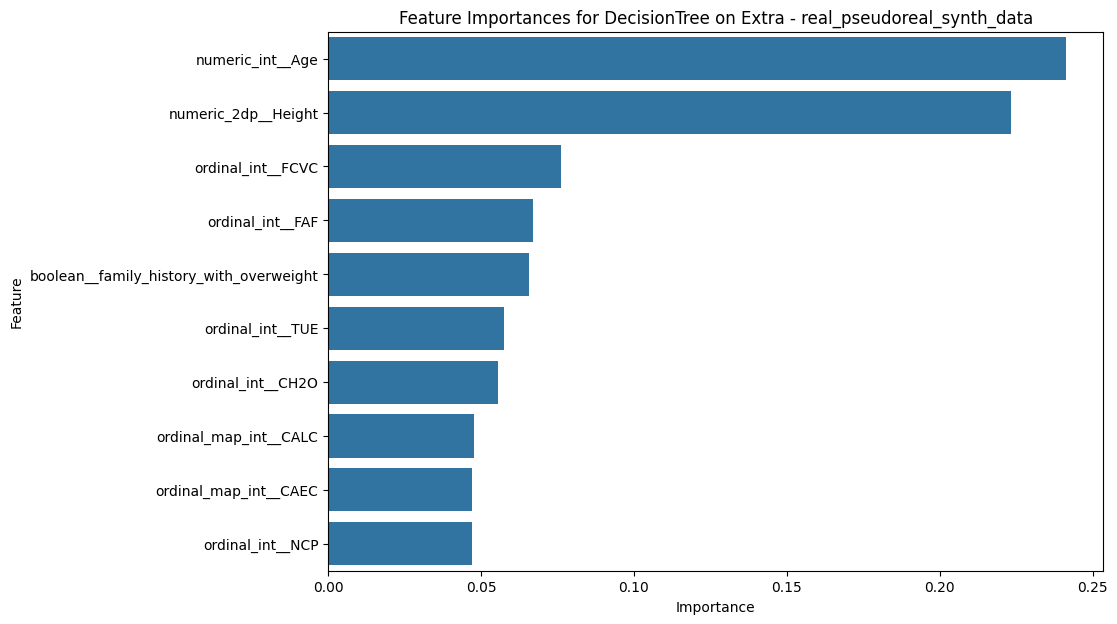

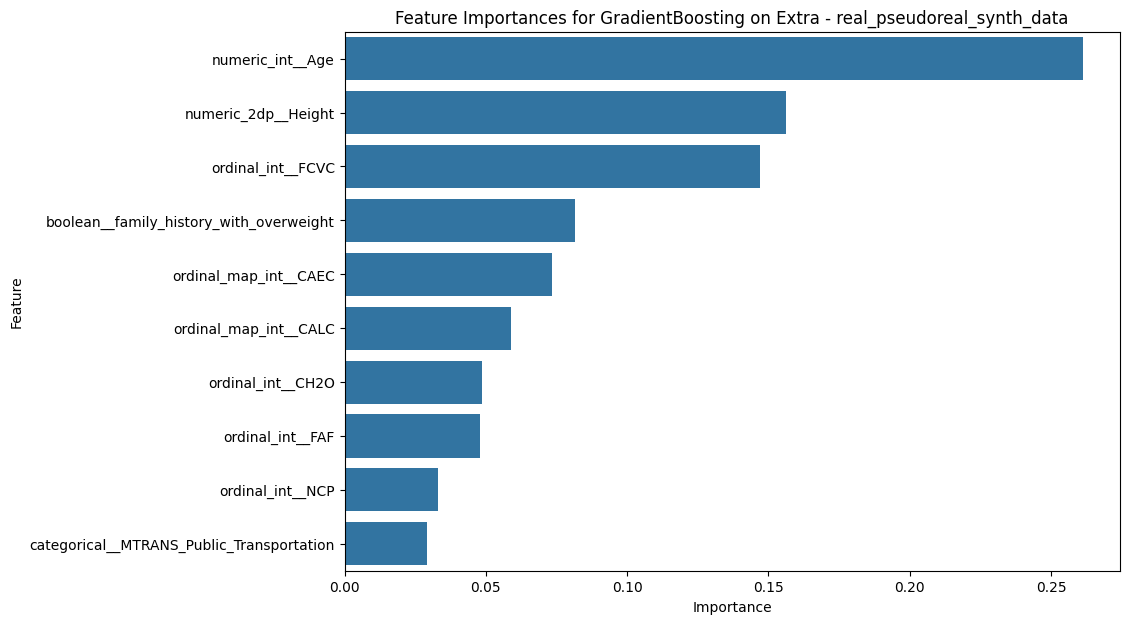

In [5]:
# Plot the feature importances
for (approach, dataset, model_name), fi_df in fi.items():
    if fi_df is not None:
        plt.figure(figsize=(10, 7))
        sns.barplot(x='Importance', y='Feature', data=fi_df.head(10))
        plt.title(f"Feature Importances for {model_name} on {approach} - {dataset}")
        plt.xlabel('Importance')
        plt.ylabel('Feature')
        plt.show()

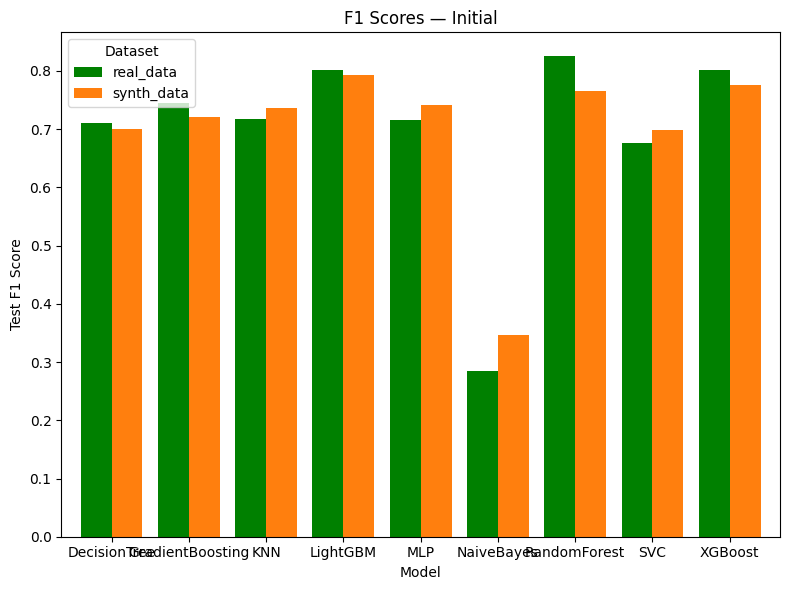

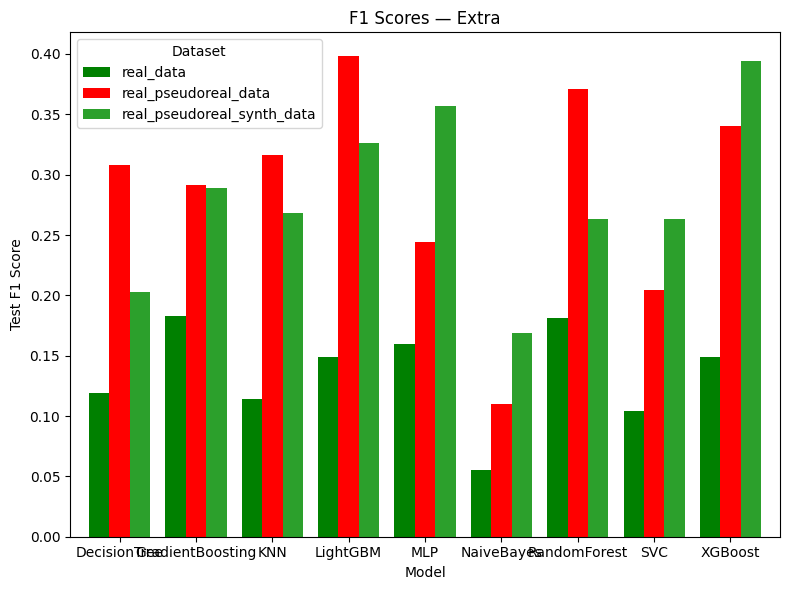

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

# === your results dict here ===
# results = {
#     ('Initial', 'real_data', 'ModelA'): {'test_f1': 0.72, …},
#     ('Initial', 'real_pseudoreal_data', 'ModelA'): {'test_f1': 0.68, …},
#     …
# }

# 1) Flatten into a DataFrame
records = []
for (approach, dataset, model), metrics in results.items():
    records.append({
        'approach': approach,
        'dataset': dataset,
        'model': model,
        'f1': metrics['test_f1']
    })
df = pd.DataFrame.from_records(records)

# 2) Define the explicit color map for known datasets
color_map = {
    'real_data': 'green',
    'real_pseudoreal_data': 'red',
    # add other explicit mappings here…
}

# 3) Plotting helper
def plot_approach(df, approach_name):
    sub = df[df['approach'] == approach_name]
    pivot = sub.pivot(index='model', columns='dataset', values='f1')
    
    # Build a colors list, falling back to the default cycle
    default_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
    default_iter = iter(default_cycle)
    colors = [
        color_map.get(ds, next(default_iter))
        for ds in pivot.columns
    ]
    
    ax = pivot.plot(
        kind='bar',
        figsize=(8, 6),
        width=0.8,
        color=colors
    )
    ax.set_title(f'F1 Scores — {approach_name}')
    ax.set_ylabel('Test F1 Score')
    ax.set_xlabel('Model')
    ax.legend(title='Dataset')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

# 4) Draw both charts
plot_approach(df, 'Initial')
plot_approach(df, 'Extra')
